In [6]:
!pip install keras_tuner

#@title Set up the environment
import os
import numpy as np, os, sys, joblib
import pandas as pd
pd.set_option('display.max_colwidth', None)
import pickle

import re

from datetime import datetime
from time import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns
import tarfile

from scipy import optimize
from scipy.io import loadmat
from scipy.signal import butter, lfilter, filtfilt, resample

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split


from keras.preprocessing.sequence import pad_sequences
import math

import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras import metrics
from keras.initializers import GlorotUniform
import keras_tuner as kt

tfk = tf.keras
tfkl = tf.keras.layers 
K = tf.keras.backend

from natsort import natsorted

import random

import keras.backend as K
K.set_image_data_format('channels_last')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [3]:
#@title Mount the *My Drive* folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
input_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/training_set' # personal Pedro
# input_directory = '/content/drive/My Drive/Project/training_set' # Blue pedro

exp_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments' # personal Pedro
# exp_directory = '/content/drive/My Drive/Project/experiments' # Blue pedro

rsults_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/Results' # personal Pedro
# rsults_directory = '/content/drive/My Drive/Project/Results' # Blue pedro

figures_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/figures' # personal Pedro
# figures_directory = '/content/drive/My Drive/Project/figures' # Blue pedro


In [5]:
#@title List content of `input_directory`

input_directory_content = os.listdir(input_directory)
input_directory_content

['S002_128.mat',
 'S001_128_ann.mat',
 'S002_128_ann.mat',
 'S002_128_rpk.mat',
 'S001_128.mat',
 'S001_128_rpk.mat',
 'S005_128_ann.mat',
 'S005_128_rpk.mat',
 'S003_128_rpk.mat',
 'S004_128.mat',
 'S003_128.mat',
 'S004_128_rpk.mat',
 'S003_128_ann.mat',
 'S005_128.mat',
 'S004_128_ann.mat',
 'S006_128_rpk.mat',
 'S008_128.mat',
 'S008_128_ann.mat',
 'S007_128_rpk.mat',
 'S007_128.mat',
 'S006_128_ann.mat',
 'S008_128_rpk.mat',
 'S006_128.mat',
 'S007_128_ann.mat',
 'S009_128.mat',
 'S012_128_ann.mat',
 'S009_128_ann.mat',
 'S011_128.mat',
 'S010_128_ann.mat',
 'S011_128_rpk.mat',
 'S010_128.mat',
 'S011_128_ann.mat',
 'S012_128.mat',
 'S009_128_rpk.mat',
 'S012_128_rpk.mat',
 'S010_128_rpk.mat',
 'S016_128.mat',
 'S015_128_ann.mat',
 'S015_128_rpk.mat',
 'S014_128.mat',
 'S014_128_rpk.mat',
 'S013_128_ann.mat',
 'S013_128_rpk.mat',
 'S014_128_ann.mat',
 'S013_128.mat',
 'S015_128.mat',
 'S018_128_ann.mat',
 'S017_128_rpk.mat',
 'S020_128.mat',
 'S019_128_rpk.mat',
 'S017_128.mat',
 

##***1*** Data Loading


In [6]:
#@title Utility Functions for data loading

def load_data_ecg(header_file):
  x = loadmat(header_file)
  recording = np.asarray(x['ecg'], dtype=np.float64)
  return recording

def load_data_peaks(file):
  x = loadmat(file)
  peaks = np.asarray(x['rpeaks'], dtype=np.float64)
  return peaks

def load_data_labels(file):
  x = loadmat(file)
  headers = x['labels']
  return headers

In [7]:
print('Loading data...')
# Get name of header files contained in the folder
header_files = []
ecg_files = []
peak_files = []

for f in input_directory_content:
    h = os.path.join(input_directory, f)
    p = os.path.join(input_directory, f)
    s = os.path.join(input_directory, f)
    if not f.lower().startswith('.') and f.lower().endswith('_ann.mat') and os.path.isfile(h):
        header_files.append(h)
    elif not f.lower().startswith('.') and f.lower().endswith('_rpk.mat') and os.path.isfile(p):
        peak_files.append(p)
    else:
        ecg_files.append(s)

num_files = len(header_files)
num_pfiles = len(peak_files)
num_efiles = len(ecg_files)

# Order the filenames for the labelling (_ann), rpeak loc (_rpk) and 2lead ecg signal in the same way to ensure correspondence
header_files = natsorted(header_files)
peak_files = natsorted(peak_files)
ecg_files = natsorted(ecg_files)

if num_files == num_efiles and num_efiles == num_pfiles:
  print('num of subjects = ' , num_files)

# Create empty list for recordings and header files 
headers = list()
ecgs = list()
peaks = list()
fs_list = list()

# Load .mat and .hea files for each subject using the function "load_data"
for i in range(num_files):
    header = load_data_labels(header_files[i])
    headers.append(header)
    peak = load_data_peaks(peak_files[i])
    peaks.append(peak)
    ecg = load_data_ecg(ecg_files[i])
    ecgs.append(ecg)
    fs = int(ecg_files[i][-7:-4])
    fs_list.append(fs)
    print(
        "\rLoading subject: {}/{}"
            .format(i+1, num_files),
        end=""
    )

num_subjects = len(headers)
print('\n Number of subjects', num_subjects)

Loading data...
num of subjects =  105
Loading subject: 105/105
 Number of subjects 105


In [8]:
print(headers[0].shape)
print('ecg dimensions = ', len(ecgs), ecgs[0].shape[0] / 128, ecgs[104].shape[1])
print('rpeaks dimensions = ', len(peaks), peaks[0].shape)
print('headers/labels dimensions = ', len(headers), headers[0].shape)


(2851,)
ecg dimensions =  105 1800.0 2
rpeaks dimensions =  105 (2851, 1)
headers/labels dimensions =  105 (2851,)


32872 32783
S


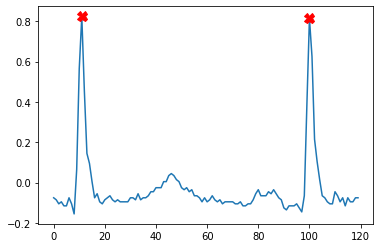

In [10]:
#@title Plot example Peaks of the non-processed ecg
subject_idx = 1

pk_loc = int(peaks[subject_idx][333][0]) + 1
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1
print(pk_loc, pk_loc_previous)

plt.plot( ecgs[subject_idx][(pk_loc-100):(pk_loc + 20), 0])

plt.plot([100], [ecgs[subject_idx][pk_loc,0]],
         marker='X',
         color='red',
         ms=10)
plt.plot([100 - (pk_loc - pk_loc_previous)],
         ecgs[subject_idx][pk_loc_previous,0],
         marker='X', color='red',
         ms=10)


print(headers[subject_idx][101][0])


##***2*** Input Building

###***2.1*** Preprocessing of the ecg data

Filter ecg signal of every subject, normalisation with mean and std and Resampling to lower freq



In [11]:
#@title Define useful preprocessing functions
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

def normalisation_function (ecg):
  X = ecg
  # Normalisation - Z-score
  rec_mean = np.nanmean(X)
  rec_std = np.nanstd(X)
  X = (X - rec_mean)/rec_std
  return X

def signal_preprocessing(data, fs): 
  # BP Filtering
  filtered_ecg = bandpass_filter(data, 1, 35, fs, 3)
  # Normalisation - Z-score
  X = normalisation_function(filtered_ecg)
  return X

In [12]:
#@title Filtering/Normalising/Resampling
# Filter ecg signal of every subject, normalisation with mean and std and Resampling to lower freq
ecgs_filt = list()
peaks_rs = list()
fs_final = min(fs_list)

# Pre processing the the full ecg signal from each patient
for i in range(len(ecgs)):
  filt_ecg1 = np.empty((len(ecgs[i][:,0]),1))
  filt_ecg1[:,0] = signal_preprocessing(ecgs[i][:,0], fs_list[i])
  filt_ecg2 = np.empty((len(ecgs[i][:,1]),1))
  filt_ecg2[:,0] = signal_preprocessing(ecgs[i][:,1], fs_list[i])

  # Resampling to lower freq for complexity reasons
  n_samples = len(filt_ecg2)
  fs = fs_list[i]
  duration = n_samples / fs
  filt_ecg1_rs = resample(filt_ecg1, int(duration * fs_final))
  filt_ecg2_rs = resample(filt_ecg2, int(duration * fs_final))
  filt_res_ecg = np.concatenate((filt_ecg1_rs, filt_ecg2_rs), axis=1)
  ecgs_filt.append(filt_res_ecg)

  # Updating the sample number of the new peaks rounding to closest sample
  rs_peak_subj = np.empty((len(peaks[i]),1))
  rs_peak_subj = np.ceil(peaks[i] * fs_final / fs)
  peaks_rs.append(rs_peak_subj.astype(int))


In [13]:
print(headers[0].shape)
print('ecg dimensions = ', len(ecgs_filt), ecgs_filt[0].shape[0], ecgs_filt[0].shape[1])
print('rpeaks dimensions = ', len(peaks_rs), peaks_rs[0].shape)
print('headers/labels dimensions = ', len(headers), headers[0].shape)

(2851,)
ecg dimensions =  105 230400 2
rpeaks dimensions =  105 (2851, 1)
headers/labels dimensions =  105 (2851,)


32872 32783
32872 32783


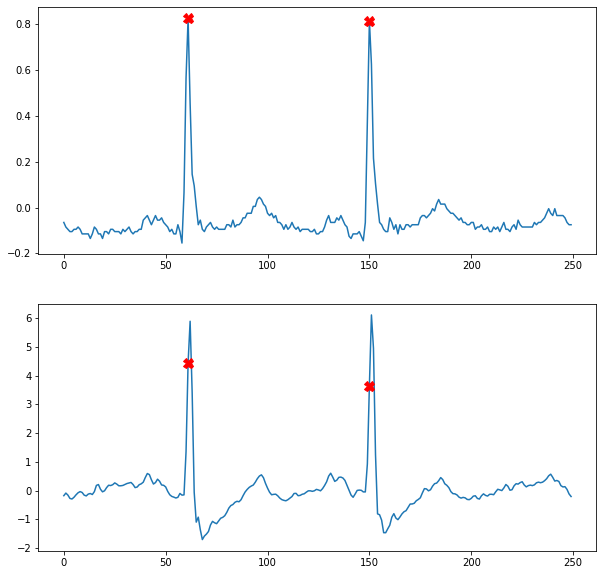

In [14]:
#@title Plotting pre processed vs non-pre processed ecg

subject_idx = 1

pk_loc = int(peaks_rs[subject_idx][333][0]) + 1
pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1
print(pk_loc, pk_loc_previous)

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.plot( ecgs_filt[subject_idx][(pk_loc-150):(pk_loc + 100), 0])
plt.plot([150], [ecgs_filt[subject_idx][pk_loc,0]],
         marker='X',
         color='red',
         ms=10)
plt.plot([150 - (pk_loc - pk_loc_previous)],
         ecgs_filt[subject_idx][pk_loc_previous,0],
         marker='X', color='red',
         ms=10)

pk_loc = int(peaks[subject_idx][333][0]) + 1 #+ 4
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1 #+ 4
print(pk_loc, pk_loc_previous)

plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-150):(pk_loc + 100), 0])
plt.plot([150], [ecgs[subject_idx][pk_loc,0]],
         marker='X',
         color='red',
         ms=10)
plt.plot([150 - (pk_loc - pk_loc_previous)],
         ecgs[subject_idx][pk_loc_previous,0],
         marker='X', color='red',
         ms=10)

32876 32787
32872 32783
32872 32783


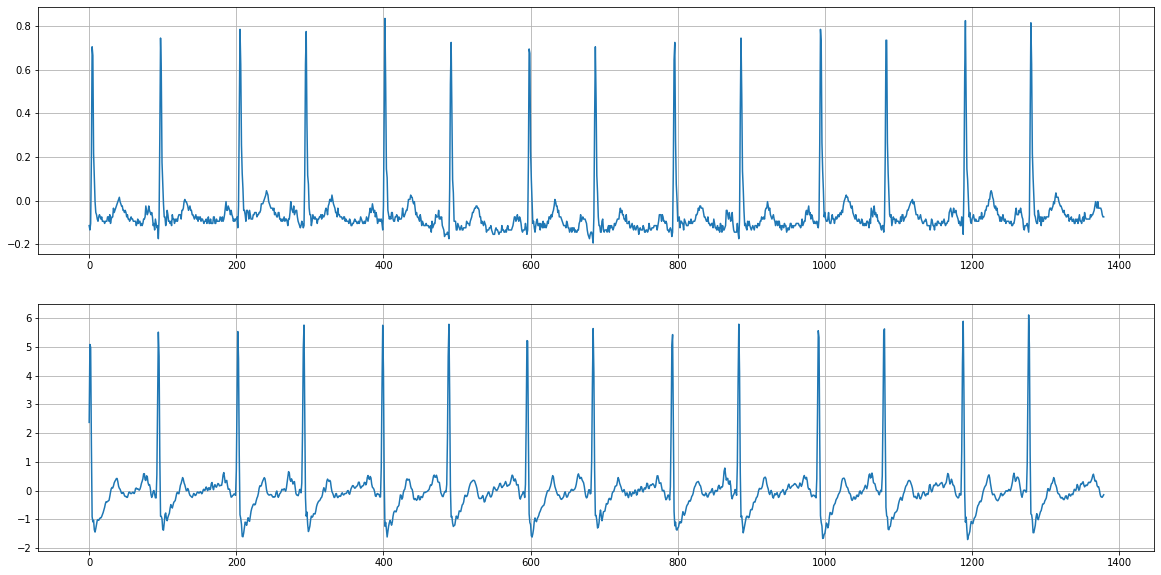

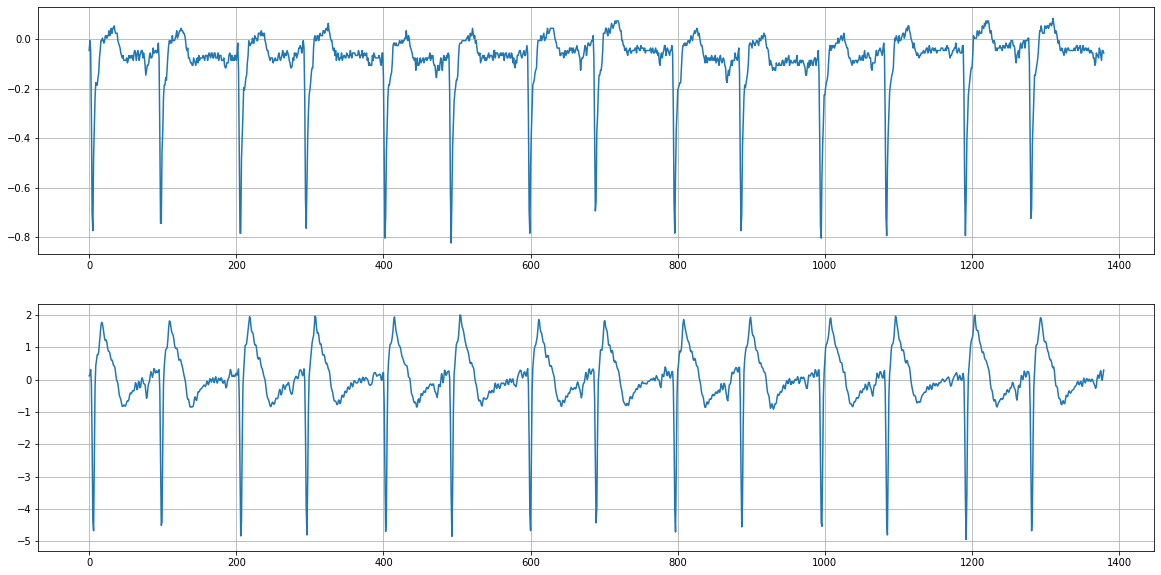

In [15]:
#@title Plotting longer of pre processed vs non-pre processed ecg

subject_idx = 1

length_time = 10

pk_loc = int(peaks_rs[subject_idx][333][0]) + 1 + 4
pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1 + 4
print(pk_loc, pk_loc_previous)

plt.figure(figsize=(20,10))
plt.subplot(2,1,2)
plt.plot( ecgs_filt[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 0])
plt.grid(0.3)

pk_loc = int(peaks[subject_idx][333][0]) + 1 #+ 4
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1 #+ 4
print(pk_loc, pk_loc_previous)

plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 0])
plt.grid(0.3)
plt.savefig(figures_directory + '/lead0_pp_npp.png')


plt.figure(figsize=(20,10))
plt.subplot(2,1,2)
plt.plot( ecgs_filt[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 1])
plt.grid(0.3)

pk_loc = int(peaks[subject_idx][333][0]) + 1 #+ 4
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1 #+ 4
print(pk_loc, pk_loc_previous)

plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 1])
plt.grid(0.3)
plt.savefig(figures_directory + '/lead1_pp_npp.png')



###***2.2*** Building inputs sequences based on the R peaks position, per subject and padding to a predefined fixed length


In [16]:
#@title Input Sequences parameters
sample_predefined_len = 225
left_factor = 1
right_factor = 0.6

In [17]:
# List with samples correlated by index
input_ecg_windows = list()
input_labels = list()
samples_origin = list()

median_hb_subj = list()
rr_int_per_subj = list()

# Get median RR per patient
for i in range(len(ecgs_filt)):
  rpeaks = peaks_rs[i]
  # Vec with all the RR interval duration (in n_samples) for the current subject
  hb_freq_vec = np.subtract(rpeaks[1:], rpeaks[:-1])
  # Int value of the median RR interval duration (in n_samples) for the current subject
  median_hb_durantion = np.median(hb_freq_vec)
  # Store vec and median val
  median_hb_subj.append(median_hb_durantion)
  rr_int_per_subj.append(hb_freq_vec)

# Determining median RR across patients
median_median_hb_duration = np.median(median_hb_subj)

# Defining heart beat window for model input
# Using 1.2 times the median RR interval (across patients) according to https://www.hindawi.com/journals/jhe/2021/7167891/
input_window_length_left = int(median_median_hb_duration * left_factor)
input_window_length_right = int(round(median_median_hb_duration * right_factor))

# Across subjects
for i in range(len(ecgs_filt)):
  current_labels = headers[i]
  rpeaks = peaks_rs[i]
  current_ecgs = ecgs_filt[i]
  fs = fs_list[i]

  input_window_length_left = int(median_hb_subj[i] * left_factor)
  input_window_length_right = int(round(median_hb_subj[i] * right_factor))
  no_samples = input_window_length_left + input_window_length_right

  if no_samples < sample_predefined_len:
    n_padding = sample_predefined_len - no_samples
  else:
    print('pre defined num of samples is less than current no_samples')
    print(no_samples, sample_predefined_len)
    break

  for rpeak_index in range(len(rpeaks)):
    current_peak = rpeaks[rpeak_index][0]
    sample_i = current_peak - input_window_length_left
    sample_f = current_peak + input_window_length_right
    # Discard peaks on the edges of the ecg recordings
    if sample_i > 0 and sample_f < len(current_ecgs):
      input_widnow1 = np.empty((no_samples,1))
      input_widnow1[:,0] = current_ecgs[sample_i:sample_f,0]
      input_widnow2 = np.empty((no_samples,1))
      input_widnow2[:,0] = current_ecgs[sample_i:sample_f,1]
      # Adding padding
      padding_vec = np.zeros((n_padding,1))
      padded_input_widnow1 = np.concatenate((input_widnow1, padding_vec), axis=0)
      padded_input_widnow2 = np.concatenate((input_widnow2, padding_vec), axis=0)
      # Creating sample
      input_widnows = np.concatenate((padded_input_widnow1, padded_input_widnow2), axis=1)
      input_ecg_windows.append(input_widnows)
      # Get this peak's label
      current_label = current_labels[rpeak_index]
      input_labels.append(current_label)
      # Get this samples's subject index
      samples_origin.append(i)
      # if n_padding < 10 and i == 39 and current_label == 'S': 
      #   print(len(input_ecg_windows)-1)
      #   print(current_label)
      #   print(i)

n_samples = len(input_ecg_windows)
# Convert to array
input_ecg_windows = np.asarray(input_ecg_windows)
print('Total set dimension = ', n_samples)
print('Sample shape = ', input_ecg_windows.shape)


Total set dimension =  244181
Sample shape =  (244181, 225, 2)


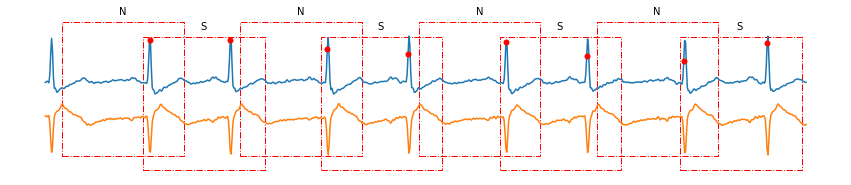

In [18]:
# Plotting segmentation scheme
subject_idx = 1
center_peak_idx = 333
displacemnet = 400

pk_loc = int(peaks_rs[subject_idx][center_peak_idx][0]) + 1
# pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1

plt.figure(figsize= (15,3))
plt.plot( ecgs_filt[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 0])

counter = 0
for peak in [-3,-2,-1,0,1,2,3,4]:
  pk_loc_other = int(peaks_rs[subject_idx][center_peak_idx + peak][0]) + 1 
  offset = (pk_loc - pk_loc_other)
  plt.plot([displacemnet - offset], [ecgs_filt[subject_idx][pk_loc_other,0]],
          marker='.',
          color='red',
          ms=10)

  top_left_corner_x = displacemnet - offset - int(median_hb_subj[subject_idx] * 1)
  top_left_corner_y = -11 + (-1)**counter
  top_len = int(median_hb_subj[subject_idx] * 1) + int(median_hb_subj[subject_idx] * 0.4)
  side_len = 18 

  plt.text(displacemnet - offset - top_len/4, top_left_corner_y + side_len + 1,
           headers[subject_idx][center_peak_idx + peak])
  
  plt.gca().add_patch(Rectangle((top_left_corner_x,top_left_corner_y),
                                top_len,
                                side_len,
                                edgecolor='red',
                                facecolor='none',
                                ls = '-.',
                                lw=1))
  
  counter += 1

plt.plot( -5 + ecgs_filt[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 1])
plt.axis('off')

plt.savefig(figures_directory + '/segmentation_scheme.png')


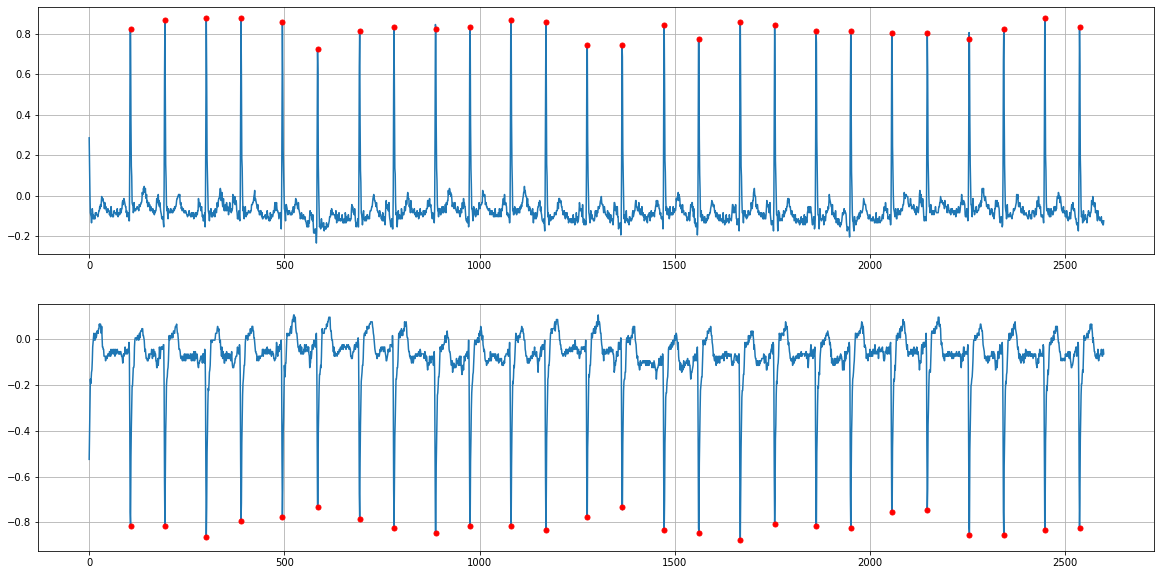

In [19]:
#@title Plotting long signal - 2 leads
subject_idx = 1
center_peak_idx = 33
displacemnet = 128 * 10

pk_loc = int(peaks_rs[subject_idx][center_peak_idx][0]) + 1 + 4
# pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1 + 4

plt.figure(figsize= (20,10))
plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 0])

counter = 0
for peak in np.arange(start=-12, step=1, stop=14):
  pk_loc_other = int(peaks_rs[subject_idx][center_peak_idx + peak][0]) + 1
  offset = (pk_loc - pk_loc_other)
  plt.plot([displacemnet - offset], [ecgs[subject_idx][pk_loc_other,0]],
          marker='.',
          color='red',
          ms=10)
  plt.grid(0.3)

  
  counter += 1


plt.subplot(2,1,2)
plt.plot(ecgs[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 1])
for peak in np.arange(start=-12, step=1, stop=14):
  pk_loc_other = int(peaks_rs[subject_idx][center_peak_idx + peak][0]) + 1
  offset = (pk_loc - pk_loc_other)
  plt.plot([displacemnet - offset], [ecgs[subject_idx][pk_loc_other,1]],
          marker='.',
          color='red',
          ms=10)
  plt.grid(0.3)

plt.savefig(figures_directory + '/leads_npp_ann.png')



Median of median RR interval duration across subjects =  100.0


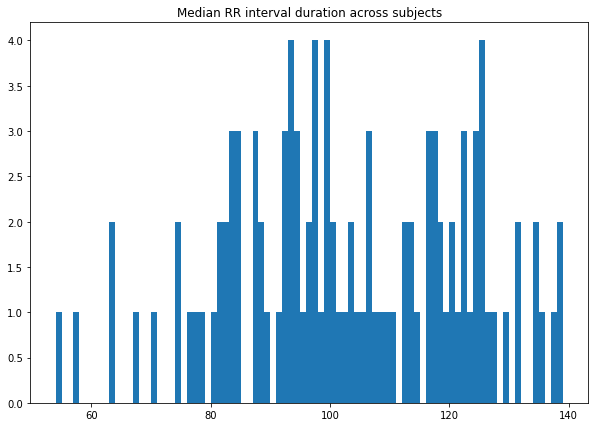

In [22]:
#@title Histogram of median RR interval duration across subjects

rr_intvector = median_hb_subj
fig = plt.figure(figsize =(10, 7))
binwidth = 1
plt.hist(rr_intvector, bins=range(int(min(rr_intvector)), int(max(rr_intvector) + binwidth), binwidth))
plt.title('Median RR interval duration across subjects')
print('Median of median RR interval duration across subjects = ', np.median(rr_intvector))

In [23]:
#Normal sinus rhythm (0), Premature ventricular complex(1), Premature atrial complex(2)
classes_name = ['N', 'V', 'S']

In [24]:
#@title Labels Encoding
num_classes = len(classes_name)
one_hot_labels = np.zeros((n_samples,num_classes), dtype=bool)
for i in range(n_samples):
  for j, x in enumerate(classes_name):
    single_label = input_labels[i]
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labxels = one_hot_labels * 1   

print(one_hot_labxels[71], one_hot_labxels[16], one_hot_labxels[69])

[0 0 1] [0 1 0] [1 0 0]


#### Plot one example sample of each class


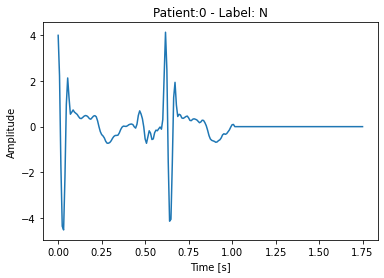

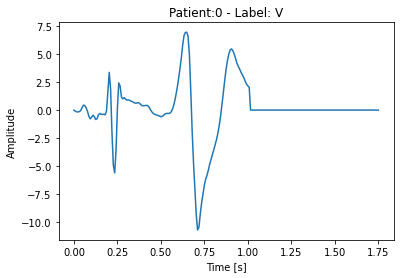

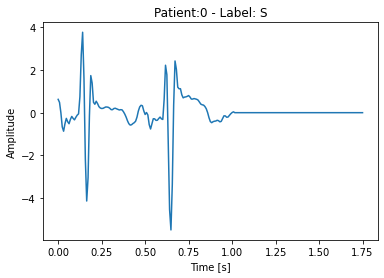

In [25]:
# Plot one example sample of ech class

sample_pac = 71
sample_pvc = 16
sample_n = 69

lead = 1

input_sample_len = len(input_ecg_windows[1])

t = np.arange(0, input_sample_len/fs_final, 1/fs_final) 
fig, axs = plt.subplots()
axs.set_title("Patient:" + str(samples_origin[sample_n]) + " - Label: " + classes_name[0])
axs.plot(t, input_ecg_windows[sample_n][:,lead], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.savefig(figures_directory + '/' +  classes_name[0] + '_example_' + str(lead))
plt.show()


fig, axs = plt.subplots()
axs.set_title("Patient:" + str(samples_origin[sample_pvc]) + " - Label: " + classes_name[1])
axs.plot(t, input_ecg_windows[sample_pvc][:,lead], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.savefig(figures_directory + '/' + classes_name[1] + '_example_' + str(lead))
plt.show()


fig, axs = plt.subplots()
axs.set_title("Patient:" + str(samples_origin[sample_pvc]) + " - Label: " + classes_name[2])
axs.plot(t, input_ecg_windows[sample_pac][:,lead], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.savefig(figures_directory + '/' + classes_name[2] + '_example_' + str(lead))
plt.show()


#### Check dataset distribution

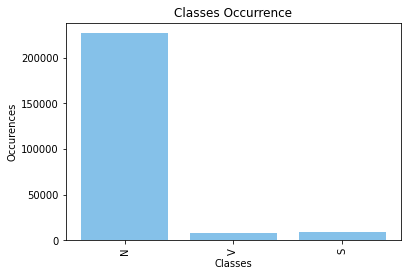

[226782   7794   9605]


In [26]:
plt.bar(x=classes_name,height=one_hot_labels.sum(axis=0), facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

print(one_hot_labels.sum(axis=0))

##***3*** Model

###***3.1*** Split


In [27]:
# Lists containing 3 fold stratified split  
X_train = list()
y_train = list()
X_val = list()
y_val = list()
X_test = list()
y_test = list()

# Define the 3-fold Cross Validator
kfold = StratifiedShuffleSplit(n_splits=3, test_size = 0.2, random_state=SEED)
# K-fold Cross Validation model evaluation
fold_no = 1
# Gneerate indexes of each training and test_val sets per each fold
for train_indexes, test_val_indexes in kfold.split(input_ecg_windows, input_labels):
  print('Split ', fold_no)
  print("TRAIN:", train_indexes, "TEST and VAL:", test_val_indexes)
  fold_no += 1 
  # Get and save k train set
  X_train_k = input_ecg_windows[train_indexes]
  y_train_k = one_hot_labxels[train_indexes]
  X_train.append(X_train_k)
  y_train.append(y_train_k)
  # Get k test and val set
  X_test_val_k = input_ecg_windows[test_val_indexes]
  y_test_val_k = one_hot_labxels[test_val_indexes]
  # Split k test and val set into val and test
  X_val_test_k = input_ecg_windows[train_indexes]
  X_test_k, X_val_k, y_test_k, y_val_k = train_test_split(X_test_val_k, y_test_val_k, test_size=0.5, random_state=SEED,
                               shuffle=True, stratify=y_test_val_k)
  X_test.append(X_test_k)
  y_test.append(y_test_k)
  X_val.append(X_val_k)
  y_val.append(y_val_k)

  print('Train set has ' + str(round(len(X_train_k)/len(input_ecg_windows)*100)) + '% of total dataset')
  print('Validation set has ' + str(round(len(X_val_k)/len(input_ecg_windows)*100)) + '% of total dataset')
  print('Test set has ' + str(round(len(X_test_k)/len(input_ecg_windows)*100)) + '% of total dataset')


Split  1
TRAIN: [214645 128137 156841 ...  97331  60741 132345] TEST and VAL: [ 10574 123289 118990 ...  36060  18785 216033]
Train set has 80% of total dataset
Validation set has 10% of total dataset
Test set has 10% of total dataset
Split  2
TRAIN: [160372 226069  32851 ... 243808 115953  52997] TEST and VAL: [ 42917 238004 211326 ... 103779 223440 210001]
Train set has 80% of total dataset
Validation set has 10% of total dataset
Test set has 10% of total dataset
Split  3
TRAIN: [ 79963 200356 129007 ... 213392  61506  21726] TEST and VAL: [114029 109448 145240 ...  22469 133418 178252]
Train set has 80% of total dataset
Validation set has 10% of total dataset
Test set has 10% of total dataset


In [28]:
#@title Input and output structure shape - K FOLD
for i in range(3):
  print('Fold', i)
  print('X_train shape = ', X_train[i].shape, '  y_train shape = ', y_train[i].shape)
  print('X_val shape = ', X_val[i].shape, '     y_val shape = ', y_val[i].shape)
  print('X_test shape = ', X_test[i].shape, '    y_test shape = ', y_test[i].shape)

Fold 0
X_train shape =  (195344, 225, 2)   y_train shape =  (195344, 3)
X_val shape =  (24419, 225, 2)      y_val shape =  (24419, 3)
X_test shape =  (24418, 225, 2)     y_test shape =  (24418, 3)
Fold 1
X_train shape =  (195344, 225, 2)   y_train shape =  (195344, 3)
X_val shape =  (24419, 225, 2)      y_val shape =  (24419, 3)
X_test shape =  (24418, 225, 2)     y_test shape =  (24418, 3)
Fold 2
X_train shape =  (195344, 225, 2)   y_train shape =  (195344, 3)
X_val shape =  (24419, 225, 2)      y_val shape =  (24419, 3)
X_test shape =  (24418, 225, 2)     y_test shape =  (24418, 3)


Inspect split folds distribution - Ensure stratification - 3 FOLD

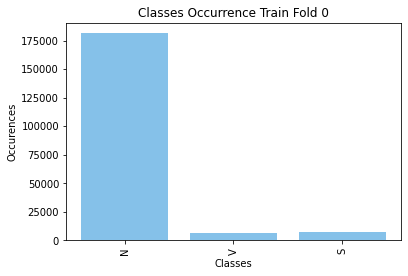

[181425   6235   7684]


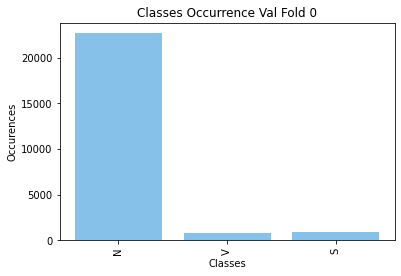

[22679   779   961]


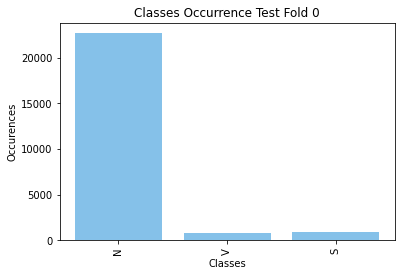

[22678   780   960]


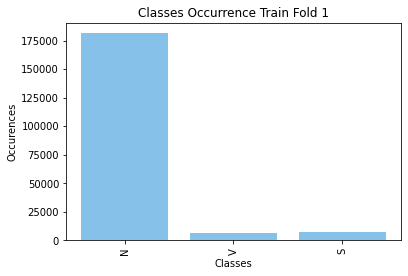

[181425   6235   7684]


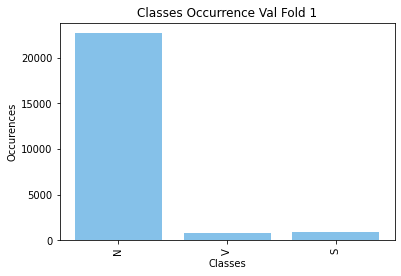

[22679   779   961]


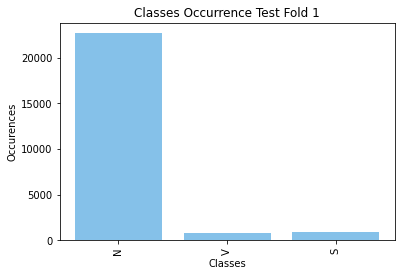

[22678   780   960]


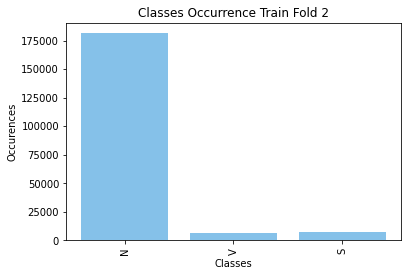

[181425   6235   7684]


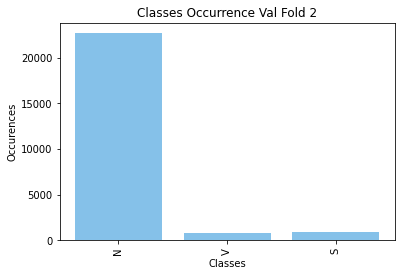

[22679   779   961]


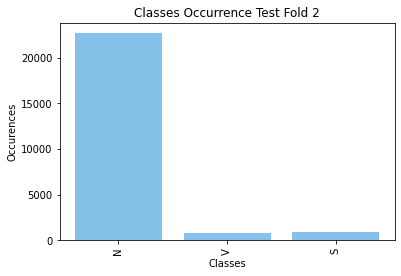

[22678   780   960]


In [29]:
for i in range(3): 
  plt.bar(x=classes_name,height=y_train[i].sum(axis=0), facecolor ='#85c1e9')
  plt.title("Classes Occurrence Train Fold " + str(i) , color = "black")
  plt.tick_params(axis="both", colors = "black")
  plt.xlabel("Classes", color = "black")
  plt.ylabel("Occurences", color = "black")
  plt.xticks(rotation=90)
  plt.yticks
  plt.show()
  print(y_train[i].sum(axis=0))
  plt.bar(x=classes_name,height=y_val[i].sum(axis=0), facecolor ='#85c1e9')
  plt.title("Classes Occurrence Val Fold " + str(i) , color = "black")
  plt.tick_params(axis="both", colors = "black")
  plt.xlabel("Classes", color = "black")
  plt.ylabel("Occurences", color = "black")
  plt.xticks(rotation=90)
  plt.yticks
  plt.show()
  print(y_val[i].sum(axis=0))

  plt.bar(x=classes_name,height=y_test[i].sum(axis=0), facecolor ='#85c1e9')
  plt.title("Classes Occurrence Test Fold " + str(i) , color = "black")
  plt.tick_params(axis="both", colors = "black")
  plt.xlabel("Classes", color = "black")
  plt.ylabel("Occurences", color = "black")
  plt.xticks(rotation=90)
  plt.yticks
  plt.show()
  print(y_test[i].sum(axis=0))


### 3.2 Compute Class Weights

"treat every instance of class 1 as 50 instances of class 0" means that in your loss function you assign higher value to these instances. Hence, the loss becomes a weighted average, where the weight of each sample is specified by class_weight and its corresponding class.

In [30]:
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(np.argmax(y_train[0],axis=1)),
                                                  y=np.argmax(y_train[0],axis=1))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.3589068026273483, 1: 10.443410852713178, 2: 8.474058650008676}

In [31]:
# No SMOTE in this notebook

# print('SMOTE? Choose from Y/N: ')
# valid = False
# while valid == False:
#   smote = input()
#   if smote != 'Y' and smote != 'N':
#     print('Invalid selection. Choose from available options.')
#   else:
#     valid = True 
#     print('Split chosen was: ', smote)

# if smote == 'Y':
#   X_train_final = X_train_res
#   y_train_final = y_train_res
#   print('SMOTE TRAINING DATA')

# else:
#   X_train_final = X_train
#   y_train_final = y_train
#   print('ORIGINAL TRAINING DATA')

smote = 'N'

SMOTE? Choose from Y/N: 
N
Split chosen was:  N
ORIGINAL TRAINING DATA


### 3.3 Define Metrics

In [32]:
# Code source
# https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras/59967457#59967457

def f1_score_macro(true, pred): #shapes (batch, 3)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 3)

    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (3,)

    macro_f1 = K.mean(f1)
    
    return macro_f1 #for metrics, return only 'weighted_f1'

def f1_score_N(true, pred): # (N_batch x (3x1))
  #for metrics include these two lines, for loss, don't include them
  #these are meant to round 'pred' to exactly zeros and ones
  predLabels = K.argmax(pred, axis=-1)
  pred = K.one_hot(predLabels, 3)

  ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
  pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
  true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

  precision = true_positives / pred_positives 
  recall = true_positives / ground_positives
      #both = 1 if ground_positives == 0 or pred_positives == 0
      #shape (3,)

  f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
      #still with shape (3,)
  return f1[0]

def f1_score_V(true, pred): # (N_batch x (3x1))
  #for metrics include these two lines, for loss, don't include them
  #these are meant to round 'pred' to exactly zeros and ones
  predLabels = K.argmax(pred, axis=-1)
  pred = K.one_hot(predLabels, 3)

  ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
  pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
  true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

  precision = true_positives / pred_positives 
  recall = true_positives / ground_positives
      #both = 1 if ground_positives == 0 or pred_positives == 0
      #shape (4,)

  f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
      #still with shape (3,)
  return f1[1]

def f1_score_S(true, pred): # (N_batch x (3x1))
  #for metrics include these two lines, for loss, don't include them
  #these are meant to round 'pred' to exactly zeros and ones
  predLabels = K.argmax(pred, axis=-1)
  pred = K.one_hot(predLabels, 3)
  
  ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
  pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
  true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

  precision = true_positives / pred_positives 
  recall = true_positives / ground_positives
      #both = 1 if ground_positives == 0 or pred_positives == 0
      #shape (4,)

  f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
      #still with shape (3,)
  return f1[2]

### 3.3 Define Callbacks

In [36]:
class saveLatesModel(keras.callbacks.Callback):
    def __init__(self, modelSaveLocation):
        super(keras.callbacks.Callback, self).__init__()
        self.modelSaveLocation = modelSaveLocation

    def on_epoch_end(self, epoch, logs={}):
        self.model.save(self.modelSaveLocation, overwrite=True)

# Function to create folders and callbacks for training
def create_folders_and_callbacks(model_dir, patience_es, patience_rop, monitoring_metric, mode_metric):
      
  callbacks = []

  # Early Stopping - best weights are restored at the end o fteh training
  es_callback = tf.keras.callbacks.EarlyStopping(monitor=monitoring_metric, mode = mode_metric,  patience=patience_es, restore_best_weights=True)
  callbacks.append(es_callback)

  # Save last epoch model for overfitting visaulisation purposes
  slem_callback = saveLatesModel(modelSaveLocation= model_dir  + '/lastepoch_model')
  callbacks.append(slem_callback)

  # Reduce learning rate on plateau
  rop_callback = tfk.callbacks.ReduceLROnPlateau(monitor=monitoring_metric, mode = mode_metric, patience=patience_rop, factor=0.5, min_lr=1e-5)
  callbacks.append(rop_callback)

  return callbacks

### ***3.6*** Define all models


#### VGGNet based CNN - VGG2

https://www.hindawi.com/journals/jhe/2021/7167891/#disclosure

In [37]:
def build_Zhang2021(input_shape):
  # Build model
  model = Sequential(name="model_Zhang2021")

  model.add(Conv1D(input_shape=input_shape, filters=16, kernel_size=3, activation="relu"))
  model.add(Conv1D(filters=16,kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Flatten())

  model.add (Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add (Dense(3,activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

  return model

build_Zhang2021(input_shape = X_train[0].shape[1:]).summary()

def build_Zhang2021_elu(input_shape):
  # Build model
  model = Sequential(name="model_Zhang2021_elu")

  model.add(Conv1D(input_shape=input_shape, filters=16, kernel_size=3, activation="elu"))
  model.add(Conv1D(filters=16,kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=32, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=64, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=128, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Flatten())

  model.add (Dense(30, activation='elu'))
  model.add (Dense(3,activation='softmax'))

  return model

build_Zhang2021_elu(input_shape = X_train[0].shape[1:]).summary()


def build_Zhang2021_maxdo1(input_shape):
  # Build model
  model = Sequential(name="model_Zhang2021_maxdo1")

  model.add(Conv1D(input_shape=input_shape, filters=16, kernel_size=3, activation="relu"))
  model.add(Conv1D(filters=16,kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Dropout(0.1, seed=SEED))

  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Dropout(0.1, seed=SEED))

  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Dropout(0.1, seed=SEED))

  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Dropout(0.1, seed=SEED))

  model.add(Flatten())

  model.add (Dense(30, activation='relu'))
  model.add (Dense(3,activation='softmax'))

  return model

build_Zhang2021_maxdo1(input_shape = X_train[0].shape[1:]).summary()

def build_Zhang2021_do1max(input_shape):
  # Build model
  model = Sequential(name="model_Zhang2021_do1max")

  model.add(Conv1D(input_shape=input_shape, filters=16, kernel_size=3, activation="relu"))
  model.add(Conv1D(filters=16,kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Dropout(0.1, seed=SEED))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Dropout(0.1, seed=SEED))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Dropout(0.1, seed=SEED))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Dropout(0.1, seed=SEED))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Flatten())

  model.add (Dense(30, activation='relu'))
  model.add (Dense(3,activation='softmax'))

  return model

build_Zhang2021_do1max(input_shape = X_train[0].shape[1:]).summary()

Model: "model_Zhang2021"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 223, 16)           112       
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 16)           784       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 16)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 108, 32)           1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 106, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 53, 32)           0         
 1D)                                               

#### VGG1

In [ ]:
def build_VGG16(input_shape):
  # Build model
  model = Sequential(name = 'model_vgg')

  model.add(Conv1D(input_shape=input_shape,filters=64,kernel_size=3,padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64,kernel_size=3,padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add (Dense(512, activation='relu'))
  model.add (Dropout(0.4))
  model.add (Dense(3,activation='softmax'))

  return model

build_VGG16(input_shape = X_train[0].shape[1:]).summary()


Model: "model_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 225, 64)           448       
                                                                 
 conv1d_37 (Conv1D)          (None, 225, 64)           12352     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 112, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_38 (Conv1D)          (None, 112, 128)          24704     
                                                                 
 conv1d_39 (Conv1D)          (None, 112, 128)          49280     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 56, 128)          0         
 g1D)                                                    

#### ResNet

In [ ]:
# ResNet model definition 
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=2, win_len=5000, classes=3): 
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet) 

    # Softmax (chnaged from Sigmoid) activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet, name = 'model_resnet')

    return model

resnet(N=8, ch=X_train[0].shape[-1], win_len=X_train[0].shape[-2], classes=y_train[0].shape[-1]).summary()

Model: "model_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 225, 2)]     0           []                               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 225, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 225, 64)     256         ['conv1d_49[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 225, 64)      0           ['batch_normalization[

### **3.7** Train model

Run all this section together to train, produce results and add it to results dataframe.

In [ ]:
batchsize = 64
patience_es = 20
patience_rop = 8
epochs = 100
learning_rate = 0.001

model_name_details = '_ncw_esf1_bs' + str(batchsize) + '_smote' + smote + '_bpfilt35' + '_16len'
print(model_name_details)

print(' ================== DONOT FORGET TO CHANGE MODLE BUILDING FUNCTION MANUALLY TO WANTED MODEL IN THE CELL BELOW ==================')

_ncw_esf1_bs64_smoteN_bpfilt35_16len
 ================== DONOT FORGET TO CHANGE MODLE BUILDING FUNCTION MANUALLY TO WANTED MODEL IN THE CELL BELOW ==================


In [ ]:
now = datetime.now().strftime('%b%d_%H-%M-%S')

for fold in range(3):

  print('---------------------------------------------------------------------------------')
  print(f'Training for fold {fold} ...')

  # ========= CHANGE HERE MODEL =========
  # ==== VGG1
  # model = build_VGG16(input_shape = X_train.shape[1:]).summary()
  # ==== VGG2
  model = build_Zhang2021_maxdo1(input_shape = X_train[0].shape[1:]) # NEXT UP
  # CHANGE LENGTH 1.5
   # ==== ResNet
  # model = resnet(N=8, ch=X_train[0].shape[-1], win_len=X_train[0].shape[-2], classes=y_train[0].shape[-1])

  # ========= Defining saving directory - model_saving_dir =========  
  model_name = model.name + model_name_details
  model_dir = os.path.join(exp_directory, model_name + '_' + str(now) + '_fold' + str(fold))
  if not os.path.exists(model_dir):
      os.makedirs(model_dir)
      print('Directory created named:   ' + model_dir)

  # ========= Compile model =========
  model.compile(
      optimizer = keras.optimizers.Adam(learning_rate),
      loss = 'categorical_crossentropy',
      metrics = [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]
  )

  # ========= Create folders and callbacks and fit =========
  monitoring_metric = 'val_f1_score_macro'
  mode = 'max'
  callbacks = create_folders_and_callbacks(model_dir, patience_es, patience_rop, monitoring_metric = monitoring_metric, mode_metric = mode)

  start = time()
  history = model.fit(
      x = X_train[fold],
      y = y_train_final[fold], 
      validation_data=(X_val[fold], y_val[fold]),
      batch_size = batchsize,
      epochs = epochs,
      callbacks = callbacks
      # class_weight = class_weights
  ).history

  duration = time() - start
  print('==============================')
  print('Training took ' + str(duration) + ' seconds or about ' + str (np.round(duration/60)) + ' minutes.')
  print('==============================')

  # Save best epoch model
  model.save(model_dir + '/model')

  # Save history
  with open(model_dir + '/history', 'wb') as file:
      pickle.dump(history, file)

  print('History and Model saved at : ', model_dir)
  print('Last epoch model saved at : ' + model_dir  + '/lastepoch_model')


---------------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/100
3053/3053 [==============================] - 29s 9ms/step - loss: 0.0938 - categorical_accuracy: 0.9701 - f1_score_macro: 0.7973 - f1_score_N: 0.9856 - f1_score_V: 0.8031 - f1_score_S: 0.6032 - val_loss: 0.0667 - val_categorical_accuracy: 0.9796 - val_f1_score_macro: 0.8588 - val_f1_score_N: 0.9906 - val_f1_score_V: 0.8876 - val_f1_score_S: 0.6983 - lr: 0.0010
Epoch 2/100
3053/3053 [==============================] - 25s 8ms/step - loss: 0.0561 - categorical_accuracy: 0.9815 - f1_score_macro: 0.8759 - f1_score_N: 0.9914 - f1_score_V: 0.8883 - f1_score_S: 0.7480 - val_loss: 0.0539 - val_categorical_accuracy: 0.9830 - val_f1_score_macro: 0.8898 - val_f1_score_N: 0.9921 - val_f1_score_V: 0.9137 - val_f1_score_S: 0.7637 - lr: 0.0010
Epoch 3/100
3053/3053 [==============================] - 25s 8ms/step - loss: 0.0492 - categorical_accuracy: 0.9839 - f1_score_macro: 0.8965 - f

#### Plotting Training


In [ ]:
# model_dir = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_cw_lt_esf1_bs64_Jun04_20-14-38'
# monitoring_metric = 'val_f1_score_macro'
# mode = 'max'
# model_dir = os.path.join(exp_directory, model_name + '_' + str(now) + '_fold' + str(0))
# fold_model_dirs = [model_dir[:-1] + '0', model_dir[:-1] + '1', model_dir[:-1] + '2']
# fold_model_dirs

# monitoring_metric = 'val_f1_score_macro'
# mode = 'max'

# model_dir = os.path.join(exp_directory,os.path.basename('/content/drive/My Drive/Project/experiments/model_resnet_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_21-50-05_fold2'))
# print(model_dir)

/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_resnet_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_21-50-05_fold2


--------------------------------------------------------------------------------------
Current Fold:  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold0
BEST EPOCH =  61
Train and Val results saved at :  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold0
--------------------------------------------------------------------------------------
Current Fold:  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold1
BEST EPOCH =  82
Train and Val results saved at :  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold1
------------------------------------------------------------------

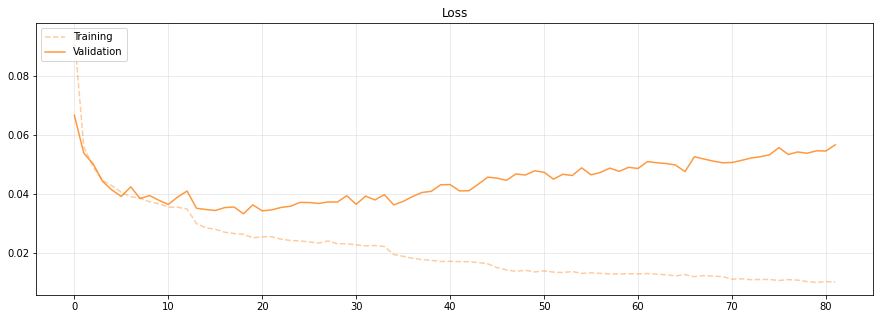

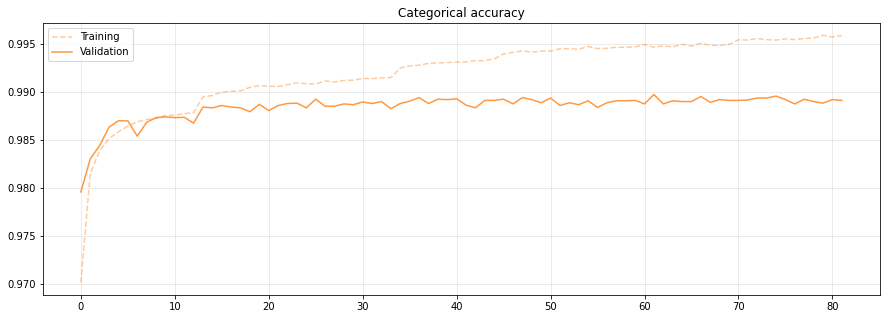

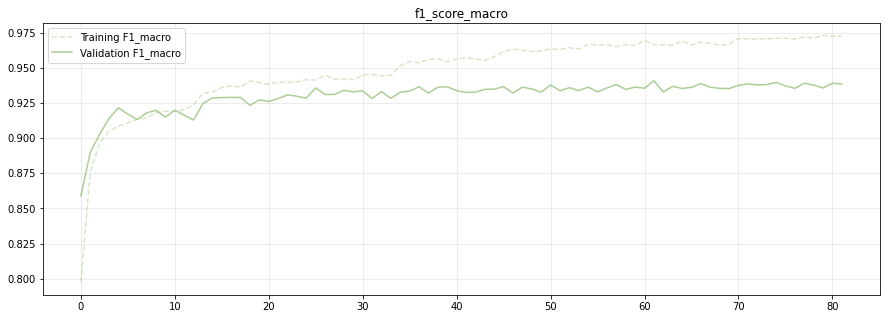

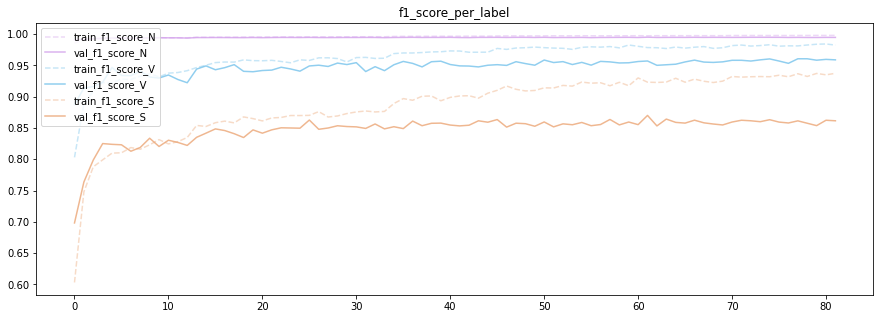

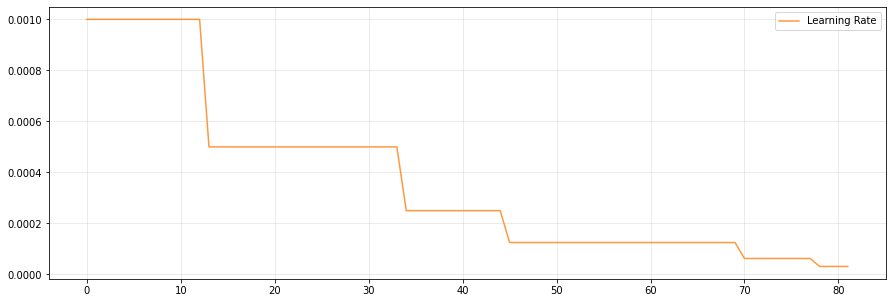

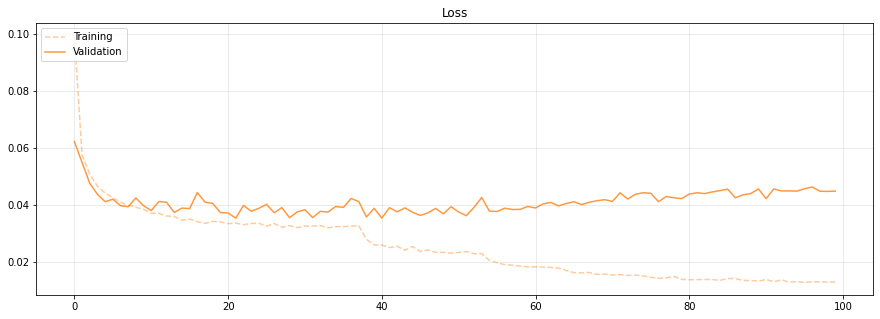

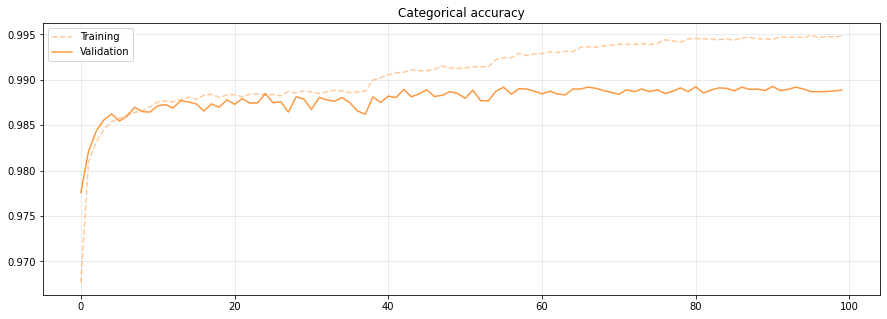

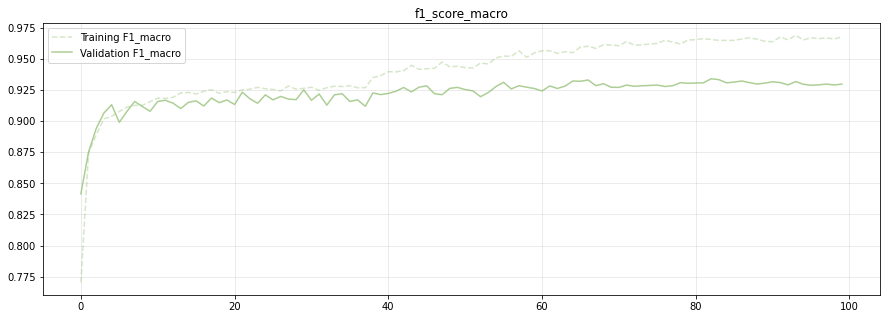

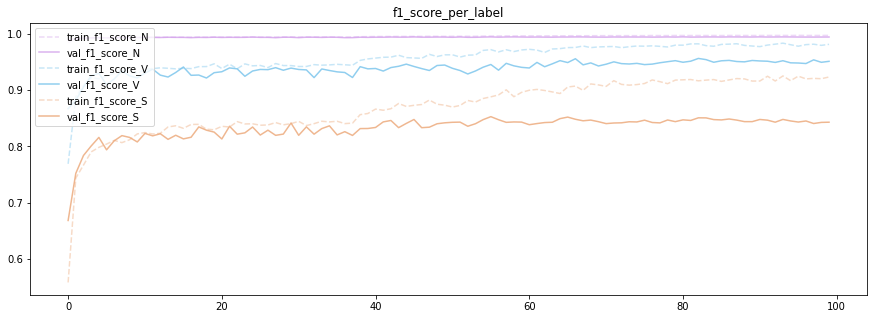

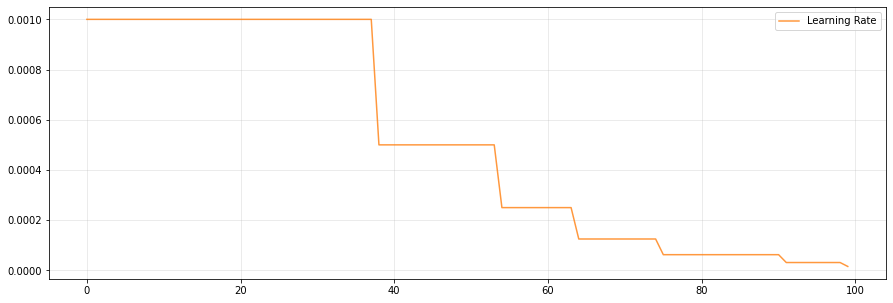

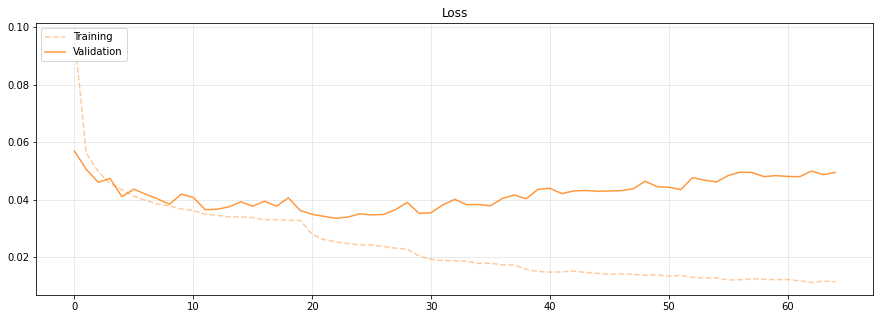

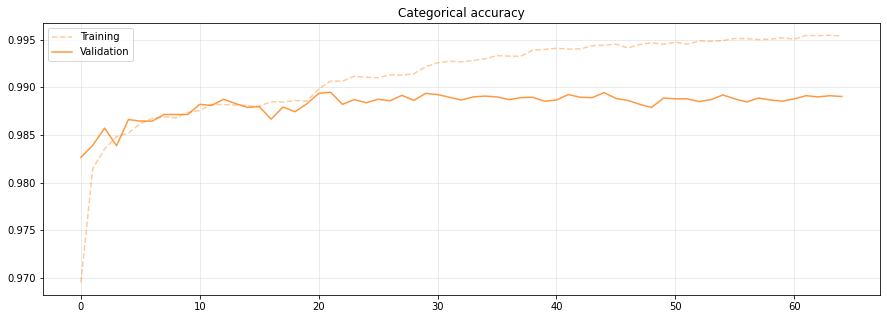

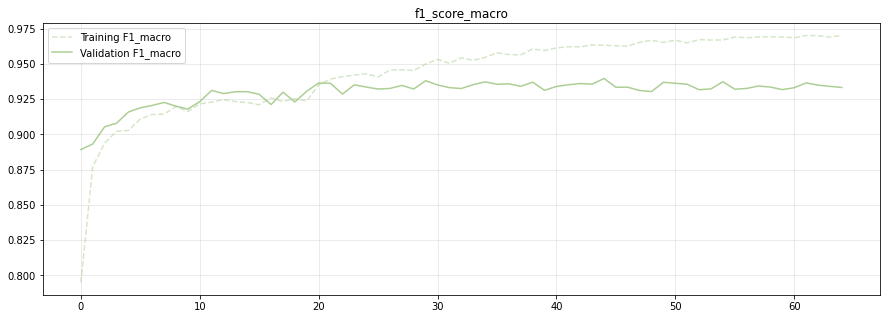

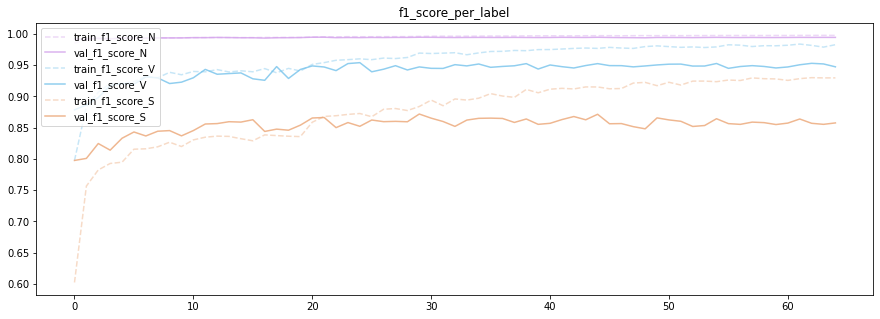

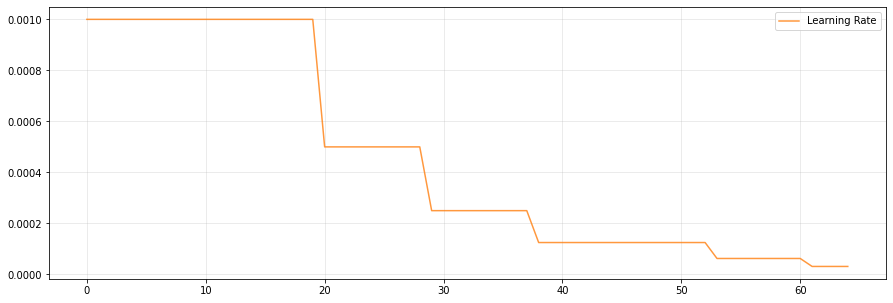

In [ ]:
fold_model_dirs = [model_dir[:-1] + '0', model_dir[:-1] + '1', model_dir[:-1] + '2']

for model_dir_k in fold_model_dirs:
  print('--------------------------------------------------------------------------------------')
  print('Current Fold: ', model_dir_k)

  #plot performances of every fold and save them in df in each respective file
  with open(model_dir_k + '/history', 'rb') as file:
    history = pickle.load(file)

  # Plot and save the training
  plt.figure(figsize=(15,5))
  plt.plot(history['loss'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
  plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Loss')
  plt.grid(alpha=.3)
  plt.savefig(model_dir_k + '/loss.png')

  plt.figure(figsize=(15,5))
  plt.plot(history['categorical_accuracy'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
  plt.plot(history['val_categorical_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Categorical accuracy')
  plt.grid(alpha=.3)
  plt.savefig(model_dir_k + '/categorical_accuracy.png')

  plt.figure(figsize=(15,5))
  plt.plot(history['f1_score_macro'], label='Training F1_macro', alpha=.4, color='#97C27A', linestyle='--')
  plt.plot(history['val_f1_score_macro'], label='Validation F1_macro', alpha=.8, color='#97C27A')
  plt.legend(loc='upper left')
  plt.title('f1_score_macro')
  plt.grid(alpha=.3)
  plt.savefig(model_dir_k + '/f1_score_macro.png')

  plt.figure(figsize=(15,5))
  plt.plot(history['f1_score_N'], label='train_f1_score_N', alpha=.4, color='#D29FEB', linestyle='--')
  plt.plot(history['val_f1_score_N'], label='val_f1_score_N', alpha=.8, color='#D29FEB')
  # plt.legend(loc='upper left')
  # plt.title('f1_score Normal HB')
  # plt.grid(alpha=.3)
  # plt.savefig(model_dir_k + '/f1_score_N.png')

  # plt.figure(figsize=(15,5))
  plt.plot(history['f1_score_V'], label='train_f1_score_V', alpha=.4, color='#75C2EB', linestyle='--')
  plt.plot(history['val_f1_score_V'], label='val_f1_score_V', alpha=.8, color='#75C2EB')
  # plt.legend(loc='upper left')
  # plt.title('f1_score PVC HB')
  # plt.grid(alpha=.3)
  # plt.savefig(model_dir_k + '/f1_score_V.png')

  # plt.figure(figsize=(15,5))
  plt.plot(history['f1_score_S'], label='train_f1_score_S', alpha=.4, color='#EBA575', linestyle='--')
  plt.plot(history['val_f1_score_S'], label='val_f1_score_S', alpha=.8, color='#EBA575')
  plt.legend(loc='upper left')
  plt.title('f1_score_per_label')
  # plt.title('f1_score PAC HB')
  # plt.grid(alpha=.3)
  # plt.savefig(model_dir_k + '/f1_score_S.png')
  plt.savefig(model_dir_k + '/f1_score_per_label.png')

  plt.figure(figsize=(15,5))
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.legend()
  plt.grid(alpha=.3)
  plt.savefig(model_dir_k + '/lr.png')

  # Create val and train rows for results df - FOR LAST EPOCH MODEL
  results_train_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir_k), 
                                            "loss":float("{:.6f}".format(history['loss'][-1])),
                                            "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][-1])),
                                            "f1_score_N":float("{:.6f}".format(history['f1_score_N'][-1])),
                                            "f1_score_V":float("{:.6f}".format(history['f1_score_V'][-1])), 
                                            "f1_score_S":float("{:.6f}".format(history['f1_score_S'][-1])),
                                            "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][-1]))},
                                            index=[0])
  results_val_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir_k), 
                                            "loss":float("{:.6f}".format(history['val_loss'][-1])),
                                            "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][-1])),
                                            "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][-1])),
                                            "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][-1])), 
                                            "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][-1])),
                                            "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][-1]))},
                                            index=[0])

  results_train_row_tr_vl_ts.to_csv(model_dir_k + '/results_train_row_tr_vl_ts.csv', index=False)
  results_val_row_tr_vl_ts.to_csv(model_dir_k + '/results_val_row_tr_vl_ts.csv', index=False)

  # Create val and train rows for results df - FOR BEST MODEL
  if mode == 'max':
    best_epoch = np.where(history[monitoring_metric] == np.amax(history[monitoring_metric]))[0][0]
  elif mode == 'min':
    best_epoch = np.where(history[monitoring_metric] == np.amin(history[monitoring_metric]))[0][0]
  print('BEST EPOCH = ', best_epoch)
  results_train_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir_k), 
                                            "loss":float("{:.6f}".format(history['loss'][best_epoch])),
                                            "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][best_epoch])),
                                            "f1_score_N":float("{:.6f}".format(history['f1_score_N'][best_epoch])),
                                            "f1_score_V":float("{:.6f}".format(history['f1_score_V'][best_epoch])), 
                                            "f1_score_S":float("{:.6f}".format(history['f1_score_S'][best_epoch])),
                                            "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][best_epoch]))},
                                            index=[0])
  results_val_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir_k), 
                                            "loss":float("{:.6f}".format(history['val_loss'][best_epoch])),
                                            "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][best_epoch])),
                                            "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][best_epoch])),
                                            "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][best_epoch])), 
                                            "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][best_epoch])),
                                            "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][best_epoch]))},
                                            index=[0])

  results_train_row_tr_vl_ts_bestepoch.to_csv(model_dir_k + '/results_train_row_tr_vl_ts_bestepoch.csv', index=False)
  results_val_row_tr_vl_ts_bestepoch.to_csv(model_dir_k + '/results_val_row_tr_vl_ts_bestepoch.csv', index=False)

  print('Train and Val results saved at : ', model_dir_k)

In [ ]:
results_train_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold2,0.011382,0.995382,0.99782,0.982907,0.929778,0.970166


In [ ]:
results_train_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_19-23-18_fold2,0.013836,0.994119,0.997229,0.971832,0.91613,0.961729


In [ ]:
results_val_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_19-23-18_fold2,0.171116,0.988084,0.994233,0.956296,0.820319,0.923616


In [ ]:
results_val_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_19-23-18_fold2,0.059915,0.989108,0.99478,0.966384,0.833321,0.931495


#### Evaluate Model

In [ ]:
fold_model_dirs

['/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold0',
 '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold1',
 '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold2']

--------------------------------------------------------------------------------------
Current Fold:  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold0
764/764 [==============================] - 4s 5ms/step - loss: 0.0424 - categorical_accuracy: 0.9896 - f1_score_macro: 0.9394 - f1_score_N: 0.9950 - f1_score_V: 0.9553 - f1_score_S: 0.8680
Test loss: 0.042386
Test categorical accuracy:  98.96%
Classes                    N        V        S
Accuracy (%):            [99.083 99.771 99.066]
Specificity (%):         [92.471 99.869 99.608]
Precision (%):           [99.423 96.056 89.956]
Sensitivity/Recall (%):  [99.59  96.795 85.833]
F1-score (%):            [0.995 0.964 0.878]
Macro Single F1-score (%):  0.9456666666666668
--------------------------------------------------------------------------------------
Current Fold:  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project

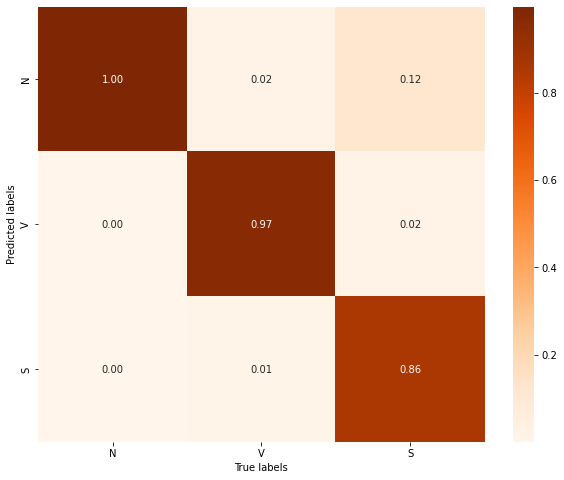

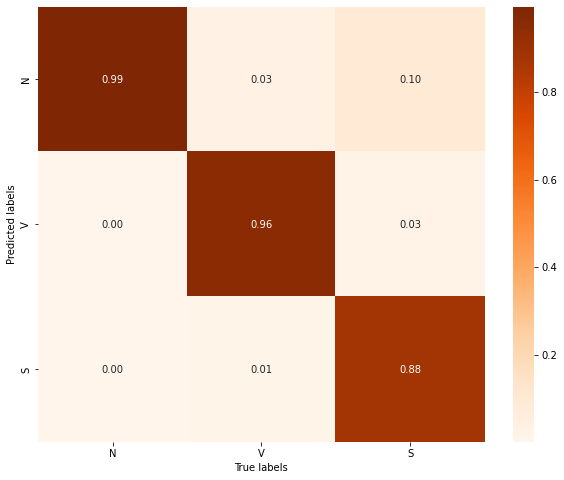

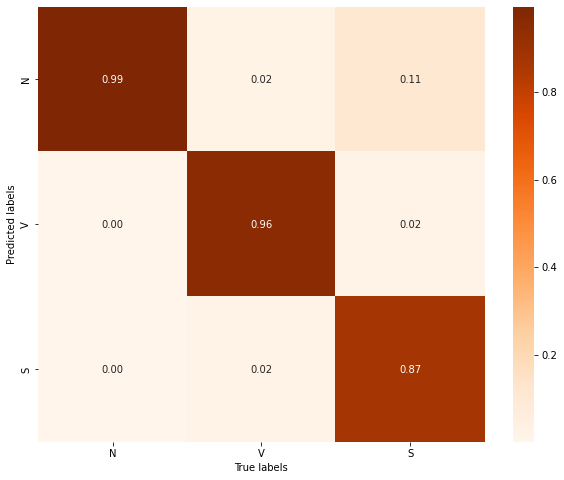

In [ ]:
fold_model_dirs = [model_dir[:-1] + '0', model_dir[:-1] + '1', model_dir[:-1] + '2']

fold_idx = 0
for model_dir_k in fold_model_dirs:

  print('--------------------------------------------------------------------------------------')
  print('Current Fold: ', model_dir_k)

  model = keras.models.load_model(model_dir_k + '/model', custom_objects={    'f1_score_macro': f1_score_macro,
                                                                            'f1_score_N': f1_score_N,
                                                                            'f1_score_V': f1_score_V,
                                                                            'f1_score_S':f1_score_S} )

  score = model.evaluate(X_test[fold_idx], y_test[fold_idx]) 
  print('Test loss: ' + str(round(score[0],6))) 
  print('Test categorical accuracy: ', str(round(score[1]*100,3)) + '%')

  # Predict test
  pred = model.predict(X_test[fold_idx]) 
  pred = np.argmax(pred, axis = 1) 
  true = np.argmax(y_test[fold_idx],axis = 1)

  # Plot and save confusion matrix
  cm = confusion_matrix(true, pred)

  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm_norm.T, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Oranges", annot=True, fmt='.2f')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(model_dir_k + '/test_confusion_matrix.png')

  # Commpute and print metrics
  FP = cm.sum(axis=0) - np.diag(cm) 
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)

  TPR = TP/(TP+FN + K.epsilon()) # Sensitivity/Recall
  TPR_oa = np.sum(TP) / (np.sum(TP) + np.sum(FN))
  TNR = TN/(TN+FP) # Specificity
  TNR_oa = np.sum(TN) / (np.sum(TN) + np.sum(FP))
  PPV = TP/(TP+FP + K.epsilon()) # Precision
  PPV_oa = np.sum(TP) / (np.sum(TP) + np.sum(FP))

  print('Classes                    N        V        S')
  print('Accuracy (%):           ', np.around(100*(TP+TN)/(TP+TN+FP+FN),3))
  print('Specificity (%):        ', np.around(TNR*100,3))
  print('Precision (%):          ', np.around(PPV*100,3))
  print('Sensitivity/Recall (%): ', np.around(TPR*100,3))

  print('F1-score (%):           ', np.around(2 / ((TPR+K.epsilon())**-1 + (PPV+ K.epsilon())**-1), 3))
  print('Macro Single F1-score (%): ', np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ))

  # To add to resulst DF
  results_test_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir_k), 
                          "loss":float("{:.6f}".format(score[0])),
                          "cat_accuracy":float("{:.6f}".format(score[1])),
                          "f1_score_N":float("{:.6f}".format(score[3])), 
                          "f1_score_V":float("{:.6f}".format(score[4])), 
                          "f1_score_S":float("{:.6f}".format(score[5])),
                          "f1_score_macro":float("{:.6f}".format(score[2]))},
                          index=[0])

  results_test_row_tr_vl_ts.to_csv(model_dir_k + '/results_test_row_tr_vl_ts.csv', index=False)

  full_test_row = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
  full_test_row.loc[0, 'Model Filename'] =  os.path.basename(model_dir_k)
  full_test_row.loc[0, 'Class'] =  ['N', 'V', 'S']
  full_test_row.loc[0, 'Accuracy'] =  np.around(100*(TP+TN)/(TP+TN+FP+FN),3).tolist()
  full_test_row.loc[0, 'Specificity'] =  np.around(TNR*100,3).tolist()
  full_test_row.loc[0, 'Precision'] =  np.around(PPV*100,3).tolist()
  full_test_row.loc[0, 'Recall'] = np.around(TPR*100,3).tolist()
  full_test_row.loc[0, 'F1-score'] =  np.around(2 / (TPR**-1 + PPV**-1), 3).tolist()
  full_test_row.loc[0, 'Macro-F1-score'] =  np.round( np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ), 3)

  full_test_row.to_csv(model_dir_k + '/full_test_row.csv', index=False)

  fold_idx += 1


#### Add results to results DF_train_val_test and DF_full_test

In [ ]:
fold_model_dirs = [model_dir[:-1] + '0', model_dir[:-1] + '1', model_dir[:-1] + '2']

for model_dir_k in fold_model_dirs:

  print('model_saving_dir: ' + model_dir_k)

  new = False
  if os.path.exists(rsults_directory + '/results_tr_vl_ts.csv') == False:
    results_tr_vl_ts = pd.DataFrame(columns=['Model Filename',
                                            'subset',
                                            'loss',
                                            'cat_accuracy',
                                            'f1_score_N',
                                            'f1_score_S',
                                            'f1_score_V',
                                            'f1_score_macro'])
    new = True
    results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

  results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

  # Current model's index on DF's
  if new:
    current_index = 0
  else:
    current_index = results_tr_vl_ts.index[-1] + 1

  # Load previously generated tes, train and val rows
  results_test_row_tr_vl_ts  = pd.read_csv(model_dir_k + '/results_test_row_tr_vl_ts.csv')
  results_train_row_tr_vl_ts = pd.read_csv(model_dir_k + '/results_train_row_tr_vl_ts_bestepoch.csv')
  results_val_row_tr_vl_ts   = pd.read_csv(model_dir_k + '/results_val_row_tr_vl_ts_bestepoch.csv')

  # We could also create easily 3 different DF for the model results on each set

  # Fill the jointDF with the data from the columns
  for col_str in results_tr_vl_ts.columns:
    if col_str == 'Model Filename':
      results_tr_vl_ts.loc[current_index, col_str] = os.path.basename(model_dir_k)
    elif col_str == 'subset':
      results_tr_vl_ts.loc[current_index, col_str] = ['train','val','test']
    else:
      train = results_train_row_tr_vl_ts.loc[0, col_str]
      val   = results_val_row_tr_vl_ts.loc[0, col_str]
      test  = results_test_row_tr_vl_ts.loc[0, col_str]

      results_tr_vl_ts.loc[current_index, col_str] = [train, val, test]

  # Save updated DF
  results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

  # Load previously generated full_test_row for current model
  full_test_row  = pd.read_csv(model_dir_k + '/full_test_row.csv')

  if os.path.exists(rsults_directory + '/full_test.csv') == False:
    full_test = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
  else:
    full_test = pd.read_csv(rsults_directory + '/full_test.csv')

  full_test_row = full_test_row.rename(index = {
    0: current_index
  })
  full_test = pd.concat([full_test, full_test_row], axis=0)

  # Save updated DF
  full_test.to_csv(rsults_directory + '/full_test.csv', index=False)

model_saving_dir: /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold0
model_saving_dir: /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold1
model_saving_dir: /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold2


In [ ]:
full_test

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_vgg_Jun01_14-53-57,"['N', 'V', 'S']","[98.071, 99.308, 98.002]","[82.874, 99.475, 99.395]","[98.693, 85.565, 81.217]","[99.237, 94.231, 63.958]","[0.99, 0.897, 0.716]",0.868
1,model_resnet_2epoch_Jun01_17-00-32,"['N', 'V', 'S']","[98.608, 99.627, 98.571]","[87.874, 99.772, 99.467]","[99.073, 93.225, 85.482]","[99.431, 95.256, 76.667]","[0.993, 0.942, 0.808]",0.914
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['N', 'V', 'S']","[98.812, 99.619, 98.792]","[88.851, 99.86, 99.523]","[99.148, 95.618, 87.402]","[99.577, 92.308, 80.938]","[0.994, 0.939, 0.84]",0.924
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
5,model_resnet_bs64_Jun04_14-50-45,"['N', 'V', 'S']","[99.169, 99.767, 99.115]","[93.563, 99.898, 99.565]","[99.507, 96.887, 89.241]","[99.599, 95.769, 88.125]","[0.996, 0.963, 0.887]",0.949
6,model_resnet_cw_bs64_Jun04_16-43-53,"['N', 'V', 'S']","[98.448, 99.726, 98.468]","[96.379, 99.835, 98.687]","[99.719, 95.07, 74.376]","[98.607, 96.41, 93.125]","[0.992, 0.957, 0.827]",0.925
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['N', 'V', 'S']","[98.047, 99.701, 98.092]","[96.897, 99.763, 98.303]","[99.758, 93.162, 69.147]","[98.135, 97.821, 92.917]","[0.989, 0.954, 0.793]",0.912
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['N', 'V', 'S']","[97.514, 99.656, 97.547]","[97.816, 99.738, 97.677]","[99.828, 92.439, 62.44]","[97.491, 97.179, 94.375]","[0.986, 0.947, 0.752]",0.895
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['N', 'V', 'S']","[97.641, 99.627, 97.678]","[97.644, 99.734, 97.813]","[99.815, 92.27, 63.848]","[97.641, 96.41, 94.375]","[0.987, 0.943, 0.762]",0.897


In [ ]:

results_tr_vl_ts

,Model Filename,subset,loss,cat_accuracy,f1_score_N,f1_score_S,f1_score_V,f1_score_macro
0,model_vgg_Jun01_14-53-57,"['train', 'val', 'test']","[0.07002, 0.068835, 0.068096]","[0.976838, 0.976782, 0.976904]","[0.989101, 0.988882, 0.989476]","[0.685058, 0.673492, 0.691116]","[0.870161, 0.875416, 0.885083]","[0.848105, 0.845929, 0.855224]"
1,model_resnet_2epoch_Jun01_17-00-32,"['train', 'val', 'test']","[0.056446, 0.047695, 0.046946]","[0.981952, 0.983457, 0.984029]","[0.991561, 0.992054, 0.9924]","[0.750074, 0.770279, 0.779728]","[0.896693, 0.906843, 0.936126]","[0.879442, 0.889725, 0.90275]"
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['train', 'val', 'test']","[0.048053, 0.045113, 0.043579]","[0.984224, 0.984972, 0.986118]","[0.99253, 0.992821, 0.993525]","[0.786369, 0.787288, 0.810451]","[0.915594, 0.917853, 0.9374]","[0.898162, 0.89932, 0.913791]"
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.012343, 0.082473, 0.035445]","[0.995153, 0.987142, 0.988657]","[0.997623, 0.993635, 0.994702]","[0.931219, 0.813162, 0.841445]","[0.979216, 0.932145, 0.959939]","[0.969352, 0.91298, 0.932028]"
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.032812, 0.03467, 0.035445]","[0.988713, 0.98833, 0.988657]","[0.994646, 0.994398, 0.994702]","[0.839198, 0.835144, 0.841445]","[0.944564, 0.941289, 0.959939]","[0.926136, 0.92361, 0.932028]"
5,model_resnet_bs64_Jun04_14-50-45,"['train', 'val', 'test']","[0.018043, 0.029661, 0.031787]","[0.993115, 0.989845, 0.990254]","[0.996708, 0.995236, 0.995462]","[0.903137, 0.858398, 0.861895]","[0.971582, 0.951401, 0.962117]","[0.957141, 0.935012, 0.939824]"
6,model_resnet_cw_bs64_Jun04_16-43-53,"['train', 'val', 'test']","[0.021232, 0.054751, 0.061469]","[0.990464, 0.985668, 0.983211]","[0.994993, 0.992735, 0.991456]","[0.872368, 0.824751, 0.791478]","[0.977793, 0.955182, 0.954702]","[0.948382, 0.924222, 0.912545]"
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['train', 'val', 'test']","[0.038509, 0.062768, 0.062349]","[0.981194, 0.98014, 0.979197]","[0.98998, 0.989953, 0.989237]","[0.788735, 0.770097, 0.746859]","[0.957377, 0.930297, 0.951051]","[0.912028, 0.896782, 0.895716]"
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['train', 'val', 'test']","[0.055368, 0.066076, 0.073789]","[0.973885, 0.974735, 0.973587]","[0.986069, 0.98698, 0.986254]","[0.732356, 0.727277, 0.705014]","[0.934867, 0.927618, 0.947304]","[0.884429, 0.880625, 0.879524]"
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['train', 'val', 'test']","[0.049204, 0.065158, 0.072744]","[0.977038, 0.976455, 0.974734]","[0.98781, 0.987842, 0.986971]","[0.75938, 0.738188, 0.720136]","[0.933524, 0.922881, 0.940231]","[0.893569, 0.88297, 0.882446]"


#### Avoidable Bias and Variance Analysis

In [7]:
# Computing variance/ measure of overfitting
# new df everytime running all computation again

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

variance_macro_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])
variance_S_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])

test_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
val_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
train_f1_score_macro = np.empty((len(results_tr_vl_ts),1))

test_f1_score_S = np.empty((len(results_tr_vl_ts),1))
val_f1_score_S = np.empty((len(results_tr_vl_ts),1))
train_f1_score_S = np.empty((len(results_tr_vl_ts),1))

for k in range(len(results_tr_vl_ts)):
  test_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_macro[k] = float(re.sub('[^\d\.]', '', results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21]))
  else:
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])
  
  test_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_S'][-9:-1])
  val_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_S'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_S'][-29:-21][0] == '[':
    train_f1_score_S[k] = float(re.sub('[^\d\.]', '', results_tr_vl_ts.loc[k,'f1_score_S'][-28:-21]))
  else:
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_S'][-29:-21])

avoidable_bias = 1 - train_f1_score_macro
variance = np.abs(train_f1_score_macro - val_f1_score_macro)
dev_test_variance = np.abs(val_f1_score_macro - test_f1_score_macro)

avoidable_bias_S = 1 - train_f1_score_S
variance_S = np.abs(train_f1_score_S - val_f1_score_S)
dev_test_variance_S = np.abs(val_f1_score_S - test_f1_score_S)

variance_macro_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_macro_df['avoidable_bias'] = avoidable_bias
variance_macro_df['variance'] = variance
variance_macro_df['dev_test_variance'] = dev_test_variance

variance_S_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_S_df['avoidable_bias'] = avoidable_bias_S
variance_S_df['variance'] = variance_S
variance_S_df['dev_test_variance'] = dev_test_variance_S

# Save updated DF
variance_S_df.to_csv(rsults_directory + '/variance_S_df.csv', index=False)
# Save updated DF
variance_macro_df.to_csv(rsults_directory + '/variance_macro_df.csv', index=False)

In [8]:
variance_S_df

,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.314942,0.011566,0.017624
1,model_resnet_2epoch_Jun01_17-00-32,0.249926,0.020205,0.009449
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.213631,0.000919,0.023163
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.068781,0.118057,0.028283
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.160802,0.004054,0.006301
5,model_resnet_bs64_Jun04_14-50-45,0.096863,0.044739,0.003497
6,model_resnet_cw_bs64_Jun04_16-43-53,0.127632,0.047617,0.033273
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.211265,0.018638,0.023238
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.267644,0.005079,0.022263
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.240620,0.021192,0.018052


In [9]:
variance_macro_df

,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.151895,0.002176,0.009295
1,model_resnet_2epoch_Jun01_17-00-32,0.120560,0.010280,0.013030
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.101840,0.001160,0.014471
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.030650,0.056370,0.019048
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.073870,0.002520,0.008418
5,model_resnet_bs64_Jun04_14-50-45,0.042859,0.022129,0.004812
6,model_resnet_cw_bs64_Jun04_16-43-53,0.051618,0.024160,0.011677
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.087972,0.015246,0.001066
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.115571,0.003804,0.001101
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.106440,0.010590,0.000524


# **4.** Compare results

Working with the results dataframes to generate the data for teh report's tables.

In [10]:
full_test = pd.read_csv(rsults_directory + '/full_test.csv')
full_test

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_vgg_Jun01_14-53-57,"['N', 'V', 'S']","[98.071, 99.308, 98.002]","[82.874, 99.475, 99.395]","[98.693, 85.565, 81.217]","[99.237, 94.231, 63.958]","[0.99, 0.897, 0.716]",0.868
1,model_resnet_2epoch_Jun01_17-00-32,"['N', 'V', 'S']","[98.608, 99.627, 98.571]","[87.874, 99.772, 99.467]","[99.073, 93.225, 85.482]","[99.431, 95.256, 76.667]","[0.993, 0.942, 0.808]",0.914
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['N', 'V', 'S']","[98.812, 99.619, 98.792]","[88.851, 99.86, 99.523]","[99.148, 95.618, 87.402]","[99.577, 92.308, 80.938]","[0.994, 0.939, 0.84]",0.924
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
5,model_resnet_bs64_Jun04_14-50-45,"['N', 'V', 'S']","[99.169, 99.767, 99.115]","[93.563, 99.898, 99.565]","[99.507, 96.887, 89.241]","[99.599, 95.769, 88.125]","[0.996, 0.963, 0.887]",0.949
6,model_resnet_cw_bs64_Jun04_16-43-53,"['N', 'V', 'S']","[98.448, 99.726, 98.468]","[96.379, 99.835, 98.687]","[99.719, 95.07, 74.376]","[98.607, 96.41, 93.125]","[0.992, 0.957, 0.827]",0.925
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['N', 'V', 'S']","[98.047, 99.701, 98.092]","[96.897, 99.763, 98.303]","[99.758, 93.162, 69.147]","[98.135, 97.821, 92.917]","[0.989, 0.954, 0.793]",0.912
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['N', 'V', 'S']","[97.514, 99.656, 97.547]","[97.816, 99.738, 97.677]","[99.828, 92.439, 62.44]","[97.491, 97.179, 94.375]","[0.986, 0.947, 0.752]",0.895
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['N', 'V', 'S']","[97.641, 99.627, 97.678]","[97.644, 99.734, 97.813]","[99.815, 92.27, 63.848]","[97.641, 96.41, 94.375]","[0.987, 0.943, 0.762]",0.897


In [11]:
results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')
results_tr_vl_ts

,Model Filename,subset,loss,cat_accuracy,f1_score_N,f1_score_S,f1_score_V,f1_score_macro
0,model_vgg_Jun01_14-53-57,"['train', 'val', 'test']","[0.07002, 0.068835, 0.068096]","[0.976838, 0.976782, 0.976904]","[0.989101, 0.988882, 0.989476]","[0.685058, 0.673492, 0.691116]","[0.870161, 0.875416, 0.885083]","[0.848105, 0.845929, 0.855224]"
1,model_resnet_2epoch_Jun01_17-00-32,"['train', 'val', 'test']","[0.056446, 0.047695, 0.046946]","[0.981952, 0.983457, 0.984029]","[0.991561, 0.992054, 0.9924]","[0.750074, 0.770279, 0.779728]","[0.896693, 0.906843, 0.936126]","[0.879442, 0.889725, 0.90275]"
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['train', 'val', 'test']","[0.048053, 0.045113, 0.043579]","[0.984224, 0.984972, 0.986118]","[0.99253, 0.992821, 0.993525]","[0.786369, 0.787288, 0.810451]","[0.915594, 0.917853, 0.9374]","[0.898162, 0.89932, 0.913791]"
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.012343, 0.082473, 0.035445]","[0.995153, 0.987142, 0.988657]","[0.997623, 0.993635, 0.994702]","[0.931219, 0.813162, 0.841445]","[0.979216, 0.932145, 0.959939]","[0.969352, 0.91298, 0.932028]"
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.032812, 0.03467, 0.035445]","[0.988713, 0.98833, 0.988657]","[0.994646, 0.994398, 0.994702]","[0.839198, 0.835144, 0.841445]","[0.944564, 0.941289, 0.959939]","[0.926136, 0.92361, 0.932028]"
5,model_resnet_bs64_Jun04_14-50-45,"['train', 'val', 'test']","[0.018043, 0.029661, 0.031787]","[0.993115, 0.989845, 0.990254]","[0.996708, 0.995236, 0.995462]","[0.903137, 0.858398, 0.861895]","[0.971582, 0.951401, 0.962117]","[0.957141, 0.935012, 0.939824]"
6,model_resnet_cw_bs64_Jun04_16-43-53,"['train', 'val', 'test']","[0.021232, 0.054751, 0.061469]","[0.990464, 0.985668, 0.983211]","[0.994993, 0.992735, 0.991456]","[0.872368, 0.824751, 0.791478]","[0.977793, 0.955182, 0.954702]","[0.948382, 0.924222, 0.912545]"
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['train', 'val', 'test']","[0.038509, 0.062768, 0.062349]","[0.981194, 0.98014, 0.979197]","[0.98998, 0.989953, 0.989237]","[0.788735, 0.770097, 0.746859]","[0.957377, 0.930297, 0.951051]","[0.912028, 0.896782, 0.895716]"
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['train', 'val', 'test']","[0.055368, 0.066076, 0.073789]","[0.973885, 0.974735, 0.973587]","[0.986069, 0.98698, 0.986254]","[0.732356, 0.727277, 0.705014]","[0.934867, 0.927618, 0.947304]","[0.884429, 0.880625, 0.879524]"
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['train', 'val', 'test']","[0.049204, 0.065158, 0.072744]","[0.977038, 0.976455, 0.974734]","[0.98781, 0.987842, 0.986971]","[0.75938, 0.738188, 0.720136]","[0.933524, 0.922881, 0.940231]","[0.893569, 0.88297, 0.882446]"


In [ ]:
import re
def NVS_table_gen (full_test, foldss_idx):
  NVS_test_df = pd.DataFrame(columns=['Model Filename',
                                      'Accuracy_N',
                                            'Accuracy_V',
                                              'Accuracy_S',
                                      'Specificity_N',
                                            'Specificity_V',
                                              'Specificity_S',
                                      'Precision_N',
                                            'Precision_V',
                                              'Precision_S',
                                      'Recall_N',
                                            'Recall_V',
                                              'Recall_S',
                                      'F1-score_N',
                                            'F1-score_V',
                                              'F1-score_S',
                                      'Macro-F1-score'])

  for col_str in full_test.columns:

    for k in foldss_idx:

      if col_str == 'Model Filename':
        NVS_test_df.loc[k, col_str] = full_test.loc[k,col_str]

      elif col_str == 'Class':
        break

      elif col_str == 'F1-score':
        NVS_test_df.loc[k, col_str + '_N'] = float(re.sub('[^\d\.]', '', full_test.loc[k,'F1-score'][-20:-15]))
        NVS_test_df.loc[k, col_str + '_V'] = float(re.sub('[^\d\.]', '', full_test.loc[k,'F1-score'][-14:-8]))
        NVS_test_df.loc[k, col_str + '_S'] = float(re.sub('[^\d\.]', '', full_test.loc[k,'F1-score'][-7:-1]))

      elif col_str == 'Macro-F1-score':
        NVS_test_df.loc[k, col_str] = full_test.loc[k,'Macro-F1-score']
        
      else:

        NVS_test_df.loc[k, col_str + '_N'] = float(re.sub('[^\d\.]', '', full_test.loc[k,col_str][-23:-17]))
        NVS_test_df.loc[k, col_str + '_V'] = float(re.sub('[^\d\.]', '', full_test.loc[k,col_str][-16:-9]))
        NVS_test_df.loc[k, col_str + '_S'] = float(re.sub('[^\d\.]', '', full_test.loc[k,col_str][-8:-1]))

  # Add new row with mean over folds
  k = k + 1
  for col_str in NVS_test_df.columns:
    if col_str == 'Model Filename':
      NVS_test_df.loc[666, col_str] = 'Mean across folds'
    else:
      sum = 0
      arr = list()
      for k in foldss_idx:
        sum += NVS_test_df.loc[k, col_str]
        arr.append(NVS_test_df.loc[k, col_str])
      NVS_test_df.loc[666, col_str] = str(round(sum / len(foldss_idx), 3)) + ' $\pm$ ' + str(round(np.std(arr), 3))

  return NVS_test_df


def NVS_table_gen_mean (full_test, foldss_idx):
  NVS_test_df = pd.DataFrame(columns=['Model Filename',
                                      'Accuracy_N',
                                            'Accuracy_V',
                                              'Accuracy_S',
                                      'Specificity_N',
                                            'Specificity_V',
                                              'Specificity_S',
                                      'Precision_N',
                                            'Precision_V',
                                              'Precision_S',
                                      'Recall_N',
                                            'Recall_V',
                                              'Recall_S',
                                      'F1-score_N',
                                            'F1-score_V',
                                              'F1-score_S',
                                      'Macro-F1-score'])

  for col_str in full_test.columns:

    for k in foldss_idx:

      if col_str == 'Model Filename':
        NVS_test_df.loc[k, col_str] = full_test.loc[k,col_str]

      elif col_str == 'Class':
        break

      elif col_str == 'F1-score':
        NVS_test_df.loc[k, col_str + '_N'] = float(re.sub('[^\d\.]', '', full_test.loc[k,'F1-score'][-20:-15]))
        NVS_test_df.loc[k, col_str + '_V'] = float(re.sub('[^\d\.]', '', full_test.loc[k,'F1-score'][-14:-8]))
        NVS_test_df.loc[k, col_str + '_S'] = float(re.sub('[^\d\.]', '', full_test.loc[k,'F1-score'][-7:-1]))

      elif col_str == 'Macro-F1-score':
        NVS_test_df.loc[k, col_str] = full_test.loc[k,'Macro-F1-score']
        
      else:

        NVS_test_df.loc[k, col_str + '_N'] = float(re.sub('[^\d\.]', '', full_test.loc[k,col_str][-23:-17]))
        NVS_test_df.loc[k, col_str + '_V'] = float(re.sub('[^\d\.]', '', full_test.loc[k,col_str][-16:-9]))
        NVS_test_df.loc[k, col_str + '_S'] = float(re.sub('[^\d\.]', '', full_test.loc[k,col_str][-8:-1]))

  # Add new row with mean over folds
  for col_str in NVS_test_df.columns:
    if col_str == 'Model Filename':
      NVS_test_df.loc[666, col_str] = full_test.loc[k,col_str][:-1] + '_AVGSTD'
    else:
      sum = 0
      arr = list()
      for k in foldss_idx:
        sum += NVS_test_df.loc[k, col_str]
        arr.append(NVS_test_df.loc[k, col_str])
      NVS_test_df.loc[666, col_str] = str(round(sum / len(foldss_idx), 3)) + ' $\pm$ ' + str(round(np.std(arr), 3))

  return NVS_test_df.drop(foldss_idx)

In [ ]:
fold_indexes = np.arange(23,47,1).reshape((-1,3))
fold_indexes, fold_indexes[7]

(array([[23, 24, 25],
        [26, 27, 28],
        [29, 30, 31],
        [32, 33, 34],
        [35, 36, 37],
        [38, 39, 40],
        [41, 42, 43],
        [44, 45, 46]]), array([44, 45, 46]))

In [ ]:
len(fold_indexes)

8

In [ ]:
i = 0
full_test_foldavgstds = NVS_table_gen_mean (full_test, fold_indexes[i])

# for i in range(len(fold_indexes)-1):
for i in range(len(fold_indexes)):
  if i != 0:
    full_test_foldavgstds = pd.concat([full_test_foldavgstds, NVS_table_gen_mean (full_test, fold_indexes[i])], axis=0)

full_test_foldavgstds.to_csv(rsults_directory + '/full_test_foldavgstds.csv', index=False)

full_test_foldavgstds

,Model Filename,Accuracy_N,Accuracy_V,Accuracy_S,Specificity_N,Specificity_V,Specificity_S,Precision_N,Precision_V,Precision_S,Recall_N,Recall_V,Recall_S,F1-score_N,F1-score_V,F1-score_S,Macro-F1-score
666,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_19-23-18_fold_AVGSTD,98.787 $\pm$ 0.056,99.681 $\pm$ 0.05,98.863 $\pm$ 0.005,89.023 $\pm$ 1.082,99.838 $\pm$ 0.028,99.589 $\pm$ 0.05,99.161 $\pm$ 0.082,95.081 $\pm$ 0.84,89.019 $\pm$ 1.045,99.537 $\pm$ 0.026,94.957 $\pm$ 0.813,81.111 $\pm$ 1.302,0.992 $\pm$ 0.002,0.948 $\pm$ 0.007,0.849 $\pm$ 0.003,0.931 $\pm$ 0.003
666,model_Zhang2021_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_20-53-15_fold_AVGSTD,98.874 $\pm$ 0.104,99.679 $\pm$ 0.016,98.933 $\pm$ 0.059,91.436 $\pm$ 0.755,99.829 $\pm$ 0.014,99.498 $\pm$ 0.056,99.344 $\pm$ 0.058,94.846 $\pm$ 0.379,87.427 $\pm$ 1.198,99.444 $\pm$ 0.071,95.128 $\pm$ 0.181,85.104 $\pm$ 0.78,0.993 $\pm$ 0.002,0.947 $\pm$ 0.005,0.862 $\pm$ 0.007,0.935 $\pm$ 0.003
666,model_Zhang2021_do1max_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_23-29-09_fold_AVGSTD,98.934 $\pm$ 0.083,99.7 $\pm$ 0.03,98.972 $\pm$ 0.082,90.843 $\pm$ 0.379,99.839 $\pm$ 0.025,99.595 $\pm$ 0.117,99.299 $\pm$ 0.029,95.154 $\pm$ 0.687,89.535 $\pm$ 2.591,99.554 $\pm$ 0.09,95.467 $\pm$ 1.087,83.75 $\pm$ 0.851,0.991 $\pm$ 0.002,0.953 $\pm$ 0.005,0.865 $\pm$ 0.008,0.937 $\pm$ 0.004
666,model_vgg_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_21-38-22_fold_AVGSTD,98.886 $\pm$ 0.033,99.663 $\pm$ 0.016,98.908 $\pm$ 0.048,91.207 $\pm$ 0.645,99.819 $\pm$ 0.023,99.511 $\pm$ 0.023,99.313 $\pm$ 0.049,94.561 $\pm$ 0.594,87.572 $\pm$ 0.6,99.445 $\pm$ 0.037,394.957 $\pm$ 424.296,84.167 $\pm$ 0.675,0.993 $\pm$ 0.002,0.948 $\pm$ 0.003,0.858 $\pm$ 0.006,0.933 $\pm$ 0.003
666,model_resnet_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_21-50-05_fold_AVGSTD,98.957 $\pm$ 0.017,99.716 $\pm$ 0.031,98.985 $\pm$ 0.023,91.82 $\pm$ 0.55,99.849 $\pm$ 0.028,99.54 $\pm$ 0.048,99.373 $\pm$ 0.041,95.447 $\pm$ 0.805,88.38 $\pm$ 0.989,99.505 $\pm$ 0.055,95.684 $\pm$ 0.697,85.417 $\pm$ 0.642,0.993 $\pm$ 0.002,0.956 $\pm$ 0.005,0.869 $\pm$ 0.002,0.939 $\pm$ 0.002
666,model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_Jun17_14-42-29_fold_AVGSTD,98.964 $\pm$ 0.052,99.712 $\pm$ 0.02,99.015 $\pm$ 0.02,92.107 $\pm$ 0.751,99.839 $\pm$ 0.026,99.554 $\pm$ 0.032,99.395 $\pm$ 0.058,95.171 $\pm$ 0.733,88.738 $\pm$ 0.684,99.508 $\pm$ 0.022,95.855 $\pm$ 0.436,85.833 $\pm$ 0.531,0.995 $\pm$ 0.0,0.955 $\pm$ 0.003,0.873 $\pm$ 0.003,0.941 $\pm$ 0.001
666,model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_15len_Jun17_17-15-02_fold_AVGSTD,99.066 $\pm$ 0.038,99.748 $\pm$ 0.049,99.046 $\pm$ 0.018,92.452 $\pm$ 0.637,99.853 $\pm$ 0.047,99.593 $\pm$ 0.035,99.42 $\pm$ 0.05,95.617 $\pm$ 1.345,89.621 $\pm$ 0.755,99.574 $\pm$ 0.06,96.538 $\pm$ 0.456,85.66 $\pm$ 0.428,0.995 $\pm$ 0.0,0.961 $\pm$ 0.007,0.876 $\pm$ 0.001,0.944 $\pm$ 0.003
666,model_Zhang2021_maxdo1_ncw_esf1_bs64_smoteN_bpfilt35_16len_Jun17_19-22-43_fold_AVGSTD,99.031 $\pm$ 0.037,99.724 $\pm$ 0.041,99.047 $\pm$ 0.021,92.854 $\pm$ 0.33,99.843 $\pm$ 0.028,99.544 $\pm$ 0.046,99.451 $\pm$ 0.023,95.299 $\pm$ 0.802,88.65 $\pm$ 0.935,99.505 $\pm$ 0.061,96.111 $\pm$ 0.495,86.909 $\pm$ 0.817,0.993 $\pm$ 0.002,0.954 $\pm$ 0.01,0.877 $\pm$ 0.002,0.943 $\pm$ 0.002


In [ ]:
# Class weights impact
# Indexes of relavanet models
foldss_idx = [7,8]

cw_vgg2_df = NVS_table_gen (full_test, foldss_idx)

cw_vgg2_df.to_csv(rsults_directory + '/cw_vgg2_df.csv', index=False)

cw_vgg2_df

,Model Filename,Accuracy_N,Accuracy_V,Accuracy_S,Specificity_N,Specificity_V,Specificity_S,Precision_N,Precision_V,Precision_S,Recall_N,Recall_V,Recall_S,F1-score_N,F1-score_V,F1-score_S,Macro-F1-score
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,98.047,99.701,98.092,96.897,99.763,98.303,99.758,93.162,69.147,98.135,97.821,92.917,0.989,0.954,0.793,0.912
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,97.514,99.656,97.547,97.816,99.738,97.677,99.82,92.43,62.44,97.491,97.179,94.375,0.986,0.947,0.752,0.895
666,Mean across folds,97.78 \pm 0.267,99.678 \pm 0.022,97.82 \pm 0.273,97.357 \pm 0.459,99.751 \pm 0.013,97.99 \pm 0.313,99.789 \pm 0.031,92.796 \pm 0.366,65.793 \pm 3.354,97.813 \pm 0.322,97.5 \pm 0.321,93.646 \pm 0.729,0.988 \pm 0.002,0.95 \pm 0.004,0.772 \pm 0.021,0.904 \pm 0.009


In [ ]:
# SMOTE impact - VGG2
# Indexes of relavanet models
foldss_idx = [18,19]

smote_vgg2_df = NVS_table_gen (full_test, foldss_idx)

smote_vgg2_df.to_csv(rsults_directory + '/smote_vgg2_df.csv', index=False)

smote_vgg2_df

,Model Filename,Accuracy_N,Accuracy_V,Accuracy_S,Specificity_N,Specificity_V,Specificity_S,Precision_N,Precision_V,Precision_S,Recall_N,Recall_V,Recall_S,F1-score_N,F1-score_V,F1-score_S,Macro-F1-score
18,model_Zhang2021_l2dense4_ncw_esf1_bs64_smoteN_bpfilt35_Jun07_16-37-02,99.001,99.685,98.948,91.897,99.843,99.527,99.3,995.2,888.0,99.546,94.872,84.792,0.995,0.951,0.864,0.937
19,model_Zhang2021_l2dense4_ncw_esf1_bs64_smoteY_bpfilt35_Jun07_18-01-15,98.58,99.71,98.55,95.69,99.831,98.849,99.66,94.93,76.44,98.8,96.15,91.25,0.992,0.955,0.832,0.926
666,Mean across folds,98.791 \pm 0.211,99.697 \pm 0.012,98.749 \pm 0.199,93.793 \pm 1.896,99.837 \pm 0.006,99.188 \pm 0.339,99.48 \pm 0.18,545.065 \pm 450.135,482.22 \pm 405.78,99.173 \pm 0.373,95.511 \pm 0.639,88.021 \pm 3.229,0.994 \pm 0.002,0.953 \pm 0.002,0.848 \pm 0.016,0.932 \pm 0.006


In [ ]:
# SMOTE impact - VGG1
# Indexes of relavanet models
foldss_idx = [16,20]

smote_vgg1_df = NVS_table_gen (full_test, foldss_idx)

smote_vgg1_df.to_csv(rsults_directory + '/smote_vgg1_df.csv', index=False)

smote_vgg1_df

,Model Filename,Accuracy_N,Accuracy_V,Accuracy_S,Specificity_N,Specificity_V,Specificity_S,Precision_N,Precision_V,Precision_S,Recall_N,Recall_V,Recall_S,F1-score_N,F1-score_V,F1-score_S,Macro-F1-score
16,model_vgg_ncw_bs64_smoteN_bpfilt35_Jun07_14-00-08,98.935,99.685,98.923,92.299,99.877,99.416,99.409,96.189,85.891,99.444,93.846,86.875,0.99,0.95,0.864,0.936
20,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,98.313,99.685,98.399,96.264,99.742,98.662,99.71,92.606,73.768,98.47,97.949,91.979,0.991,0.952,0.819,0.921
666,Mean across folds,98.624 $\pm$ 0.311,99.685 $\pm$ 0.0,98.661 $\pm$ 0.262,94.281 $\pm$ 1.982,99.809 $\pm$ 0.067,99.039 $\pm$ 0.377,99.559 $\pm$ 0.15,94.397 $\pm$ 1.791,79.829 $\pm$ 6.062,98.957 $\pm$ 0.487,95.898 $\pm$ 2.051,89.427 $\pm$ 2.552,0.99 $\pm$ 0.001,0.951 $\pm$ 0.001,0.841 $\pm$ 0.023,0.929 $\pm$ 0.008


In [ ]:
variance_macro_df.loc[foldss_idx]

,Model Filename,avoidable_bias,variance,dev_test_variance
16,model_vgg_ncw_bs64_smoteN_bpfilt35_Jun07_14-00-08,0.008930,0.062710,0.000115
20,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.005384,0.081725,0.006156


In [ ]:
variance_S_df.loc[foldss_idx]

,Model Filename,avoidable_bias,variance,dev_test_variance
16,model_vgg_ncw_bs64_smoteN_bpfilt35_Jun07_14-00-08,0.018778,0.135346,0.002648
20,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.007271,0.181564,0.034122
